In [16]:
import os
import pandas as pd #Import pandas for operations
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay


In [17]:
#0. Import data
dataframe = pd.read_csv('data/sdss_100k_galaxy_form_burst.csv', low_memory=False, header=1)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [18]:
# 0.1. Data Statistical Analysis
print(f"Dataset shape: {dataframe.shape}")

numerical_features = dataframe.select_dtypes(include='number').columns
z_scores = dataframe[numerical_features].apply(zscore)  # compute z-score for each numeric column
threshold = 3 #How many STD. we consider outlier.
outliers_z = (abs(z_scores) > threshold)

print(dataframe[outliers_z.any(axis=1)])  # rows containing at least one outlier
# Data is somewhat skewed


Dataset shape: (100000, 43)
                     objid            specobjid          ra        dec  \
4      1237648702973149350   332154249716721664  198.706864  -1.046217   
42     1237648721763238209   314301479399745536  170.073523   0.405995   
54     1237651192432165212  8192142948407990272  131.241240  53.208364   
58     1237651251482067624  7181230230211942400  122.631878  45.281591   
72     1237648704061309661  4517153671457560576  231.533375  -0.340179   
...                    ...                  ...         ...        ...   
99928  1237662236392685639  1384880019989358592  184.933948   9.148592   
99936  1237662236929622034  1384887441692846080  185.110612   9.424278   
99957  1237654381978845196   623782117049919488  140.589226  53.606884   
99968  1237664667902214147  2354413718323881984  165.917906  37.929384   
99977  1237664669494804798  1783437871319902208  121.816368  21.689839   

                u           g         r         i         z  modelFlux_u  ...  \
4 

In [19]:
# 1 Data pre-processing

# 1.1.0 Smoothen out outliers by means of Robust Scaler
robust_scaler = RobustScaler() # Initialize scaler
robust_scaled_values = robust_scaler.fit_transform(dataframe[numerical_features]) # Scale only numerical data from dataset.
robust_scaled_df = pd.DataFrame(robust_scaled_values, columns=numerical_features, index=dataframe.index) # Convert scaled data to pandas dataframe NB: index so it aligns with OG.
scaled_dataframe = dataframe.copy() # Create a copy of Dataframe to preserve original.
scaled_dataframe[numerical_features] = robust_scaled_df # Copy scaled values over into new copy.

# 1.1.1 remove unnecessary columns
modified_dataframe = scaled_dataframe.drop(['objid', 'specobjid', 'class'], axis=1)

In [20]:
# 3. Begin Training Model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#3.1. Setup Model with Params.
class galaxy_classification_nn(nn.Module):
    def __init__(self,  dropout_rate=0.4):

        # Store dropout rate.
        self.dropout_rate = dropout_rate

        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=39, out_features=133)
        self.hidden_layer2 = nn.Linear(in_features=133, out_features=133)
        self.output_layer = nn.Linear(in_features=133, out_features=2)

        # Specify activation functions.
        self.activation_function1 = nn.Tanh() # Input -> Hidden 1
        self.activation_function2 = nn.ReLU() # Hidden 1 -> Hidden 2

        # Added dropout layers.
        self.dropout_layer1 = nn.Dropout(p=self.dropout_rate) #Dropout H1 -> H2
        self.dropout_layer2 = nn.Dropout(p=self.dropout_rate) #Droput H2 -> Output


    def forward(self, x):
        x = self.hidden_layer1(x)
        x = self.activation_function1(x)
        x = self.dropout_layer1(x)

        x = self.hidden_layer2(x)
        x = self.activation_function2(x)
        x = self.dropout_layer2(x)

        x = self.output_layer(x)

        return x

    def get_weights(self, model_type):
        if model_type == 'traditional':
            init.xavier_normal_(self.input_layer.weight, )
            init.kaiming_normal(self.hidden_layer.weight)
            init.xavier_normal_(self.output_layer.weight)
            return
        elif model_type == 'sign_based':
            init.xavier_normal_(self.input_layer.weight)

In [21]:
def standardize_data(data, std_type):
    scaler = StandardScaler()
    data_scaled = None

    if std_type == 'fit':
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)

    return data_scaled

In [22]:
import torch.optim as optim

#3.2. Init. model
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")

galaxy_classification_model = galaxy_classification_nn(dropout_rate=0.4).to(device)

#3.2. Setup Optimizer
loss_function = nn.CrossEntropyLoss()

# Sign-Based approach setup
error_optimizer = optim.Rprop(
    galaxy_classification_model.parameters(),
    lr=0.01,        # initial step size per weight
    etas=(0.5, 1.2),# (eta_minus, eta_plus)
    step_sizes=(1e-6, 50.0)  # (min_step, max_step)
)

#SGD Regular setup - Control
control_error_optimizer = optim.SGD(galaxy_classification_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Hyperparameter optimization: TODO: Move Below
# Variables: Initial learning rate and dropout rate
k_fold = StratifiedKFold(n_splits=2, shuffle=True)
learning_rates_list = [0.001, 0.01, 0.05, 0.1]
dropout_rates_list = [0.2, 0.4, 0.6, 0.8]
number_of_independent_runs = 2
results_list = []
hpo_epoch_count = 10

# 1. Get Dataset Labels & Features TODO: Remove when move down.

dataset_features = modified_dataframe.select_dtypes(include=[np.number])
dataset_labels = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

for learning_rate in learning_rates_list:
    for dropout_rate in dropout_rates_list:
        print(f"Learning rate: {learning_rate}, Dropout rate: {dropout_rate}")
        fold_scores = []

        # Repeat individual runs
        for run in range(number_of_independent_runs):
            kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=run)

            for fold, (train_index, test_index) in enumerate(k_fold.split(dataset_features, dataset_labels), 1):
                print(f"\nCurrent Fold {fold}:")

                # 2. Split current folds into test and training set
                features_train, features_test = dataset_features.copy().iloc[train_index], dataset_features.copy().iloc[test_index]
                labels_train, labels_test =dataset_labels.copy().iloc[train_index], dataset_labels.copy().iloc[test_index]

                features_train_numpy = features_train.to_numpy()
                features_test_numpy = features_test.to_numpy()

                # 3. Normalize dataset
                standard_scaler = StandardScaler()
                features_train_scaled = standard_scaler.fit_transform(features_train_numpy)
                features_test_scaled = standard_scaler.transform(features_test_numpy)

                # 4. Convert to Tensors
                features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)
                features_test_tensor = torch.tensor(features_test_scaled, dtype=torch.float32)
                labels_train_tensor = torch.tensor(labels_train.to_numpy(), dtype=torch.long)
                labels_test_tensor = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

                # 5. Create Dataloaders
                training_dataset_converted = TensorDataset(features_train_tensor, labels_train_tensor)
                testing_dataset_converted = TensorDataset(features_test_tensor, labels_test_tensor)

                training_dataset_loader = DataLoader(training_dataset_converted, batch_size=64, shuffle=True)
                testing_dataset_loader = DataLoader(testing_dataset_converted, batch_size=64, shuffle=True)

                # 6. Compute class weights to address class imbalance
                class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train.to_numpy())
                class_weights = torch.tensor(class_weights, dtype=torch.float32)


                #Setup current model.
                galaxy_classification_model_hpo = galaxy_classification_nn(dropout_rate=dropout_rate).to(device)
                loss_function_hpo = nn.CrossEntropyLoss()
                error_optimizer_hpo = optim.Rprop(
                    galaxy_classification_model_hpo.parameters(),
                    lr=learning_rate,  # initial step size per weight
                    etas=(0.5, 1.2),# (eta_minus, eta_plus)
                    step_sizes=(1e-6, 50.0)  # (min_step, max_step)
                )

                # train for N epochs
                for epoch in range(hpo_epoch_count):
                    galaxy_classification_model_hpo.train()
                    for feature_batch, label_batch in training_dataset_loader:
                        error_optimizer_hpo.zero_grad()
                        outputs_hpo = galaxy_classification_model_hpo(feature_batch)
                        loss_hpo = loss_function_hpo(outputs_hpo, label_batch)
                        loss_hpo.backward()
                        error_optimizer_hpo.step()

                # evaluate
                galaxy_classification_model_hpo.eval()
                preds_hpo, true_hpo = [], []
                with torch.no_grad():
                    for feature_batch, label_batch in testing_dataset_loader:
                        outputs_eval_hpo = galaxy_classification_model_hpo(feature_batch)
                        preds_hpo.extend(torch.argmax(outputs_eval_hpo, dim=1).cpu().numpy())
                        true_hpo.extend(label_batch.cpu().numpy())

                f1 = f1_score(true_hpo, preds_hpo, average="macro")
                fold_scores.append(f1)

            avg_f1 = np.mean(fold_scores)
            std_f1 = np.std(fold_scores)
            print(f"Avg F1 for lr={learning_rate}, dropout={dropout_rate}: {avg_f1:.3f}")
            results_list.append({"learning_rate": learning_rate, "dropout": dropout_rate, "f1": avg_f1, "std_f1": std_f1})

# 2. Convert results to dataframe for visualization.
results_df = pd.DataFrame(results_list)
pivot_table_mean = results_df.pivot(index="dropout", columns="learning_rate", values="f1")
pivot_table_std = results_df.pivot(index="dropout", columns="learning_rate", values="std_f1")
print(pivot_table_mean)

# 3. Plot Heatmap.
plt.figure(figsize=(8,6))
heatmap = plt.imshow(pivot_table_mean, cmap="plasma", aspect="auto", origin="lower")

plt.colorbar(heatmap, label="Average F1-score")
plt.xticks(range(len(pivot_table_mean.columns)), pivot_table_mean.columns)
plt.yticks(range(len(pivot_table_mean.index)), pivot_table_mean.index)

plt.xlabel("Learning Rate")
plt.ylabel("Dropout Rate")
plt.title("Grid Search F1 Heatmap")

for i in range(pivot_table_mean.shape[0]):  # rows (dropout)
    for j in range(pivot_table_mean.shape[1]):  # cols (learning rate)
        mean_value = pivot_table_mean.iloc[i, j]
        std_value = pivot_table_std.iloc[i, j]
        plt.text(j, i, f"{mean_value:.3f} : {std_value:.3f}", ha="center", va="center", color="white")

plt.show()



Starting Sign-Based model training:


Current Fold 1:
Fold scores for current sign fold 1 of run 0:

Fold Accuracy Scores: [0.85184]

Fold F1 Scores: [0.7855438986544385]

Fold 1 Accuracy: 0.852, F1: 0.786
  Class 0 -> Precision: 0.873, Recall: 0.939
  Class 1 -> Precision: 0.762, Recall: 0.592
Fold 1 Accuracy: 0.852, F1: 0.786
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_1_run_0.pt with accuracy 0.786


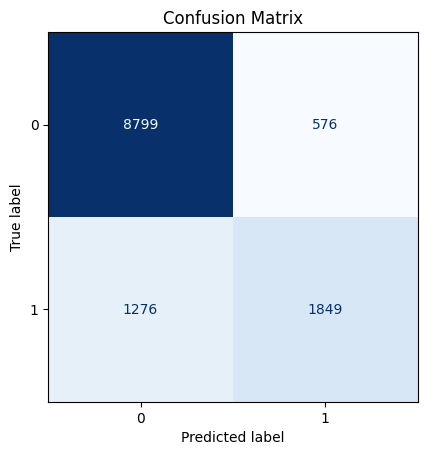


Current Fold 2:
Fold scores for current sign fold 2 of run 0:

Fold Accuracy Scores: [0.85536]

Fold F1 Scores: [0.7957218810898155]

Fold 2 Accuracy: 0.855, F1: 0.796
  Class 0 -> Precision: 0.883, Recall: 0.931
  Class 1 -> Precision: 0.752, Recall: 0.630
Fold 2 Accuracy: 0.855, F1: 0.796
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_2_run_0.pt with accuracy 0.796


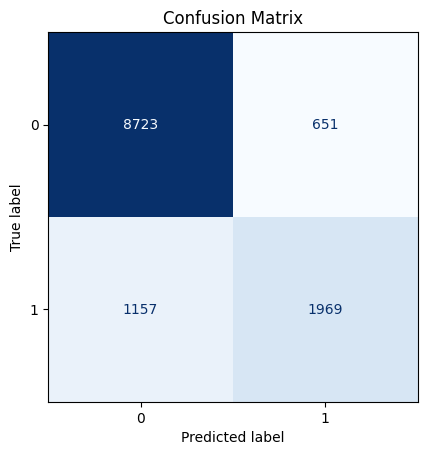


Current Fold 3:
Fold scores for current sign fold 3 of run 0:

Fold Accuracy Scores: [0.84728]

Fold F1 Scores: [0.7755929272156995]

Fold 3 Accuracy: 0.847, F1: 0.776
  Class 0 -> Precision: 0.866, Recall: 0.942
  Class 1 -> Precision: 0.764, Recall: 0.564
Fold 3 Accuracy: 0.847, F1: 0.776


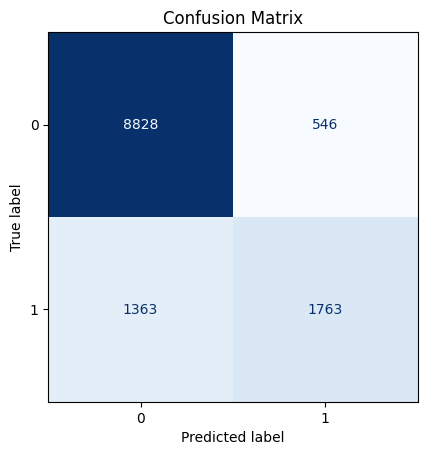


Current Fold 4:
Fold scores for current sign fold 4 of run 0:

Fold Accuracy Scores: [0.85232]

Fold F1 Scores: [0.7877629380356812]

Fold 4 Accuracy: 0.852, F1: 0.788
  Class 0 -> Precision: 0.876, Recall: 0.936
  Class 1 -> Precision: 0.758, Recall: 0.601
Fold 4 Accuracy: 0.852, F1: 0.788


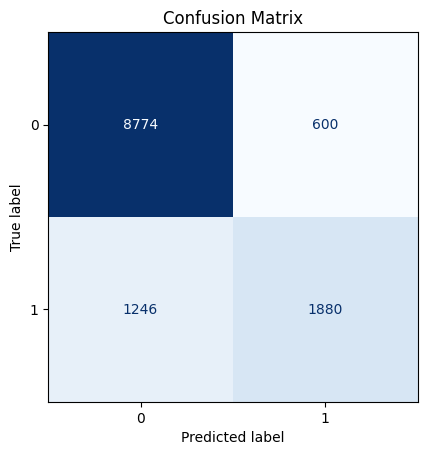


Current Fold 5:
Fold scores for current sign fold 5 of run 0:

Fold Accuracy Scores: [0.84928]

Fold F1 Scores: [0.7766536506800124]

Fold 5 Accuracy: 0.849, F1: 0.777
  Class 0 -> Precision: 0.865, Recall: 0.946
  Class 1 -> Precision: 0.776, Recall: 0.558
Fold 5 Accuracy: 0.849, F1: 0.777


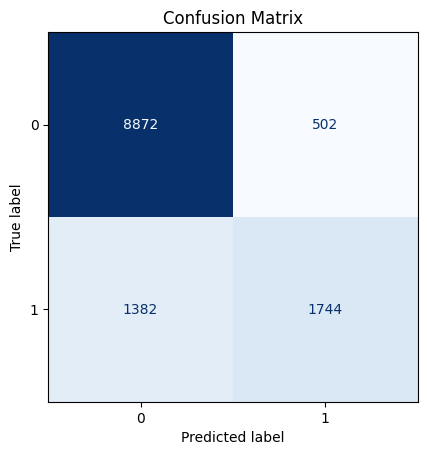


Current Fold 6:
Fold scores for current sign fold 6 of run 0:

Fold Accuracy Scores: [0.84024]

Fold F1 Scores: [0.7648730920823095]

Fold 6 Accuracy: 0.840, F1: 0.765
  Class 0 -> Precision: 0.862, Recall: 0.938
  Class 1 -> Precision: 0.746, Recall: 0.548
Fold 6 Accuracy: 0.840, F1: 0.765


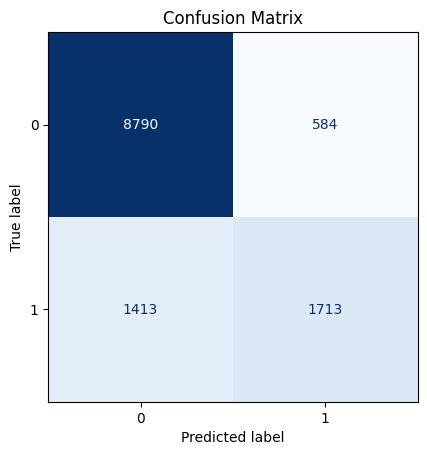


Current Fold 7:
Fold scores for current sign fold 7 of run 0:

Fold Accuracy Scores: [0.85968]

Fold F1 Scores: [0.7925691995772859]

Fold 7 Accuracy: 0.860, F1: 0.793
  Class 0 -> Precision: 0.872, Recall: 0.952
  Class 1 -> Precision: 0.803, Recall: 0.582
Fold 7 Accuracy: 0.860, F1: 0.793


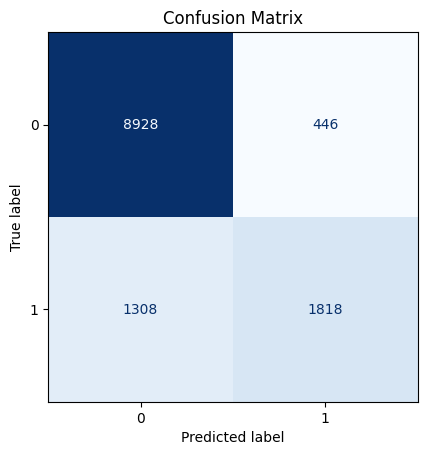


Current Fold 8:
Fold scores for current sign fold 8 of run 0:

Fold Accuracy Scores: [0.86432]

Fold F1 Scores: [0.799697656840514]

Fold 8 Accuracy: 0.864, F1: 0.800
  Class 0 -> Precision: 0.875, Recall: 0.955
  Class 1 -> Precision: 0.814, Recall: 0.592
Fold 8 Accuracy: 0.864, F1: 0.800
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_8_run_0.pt with accuracy 0.800


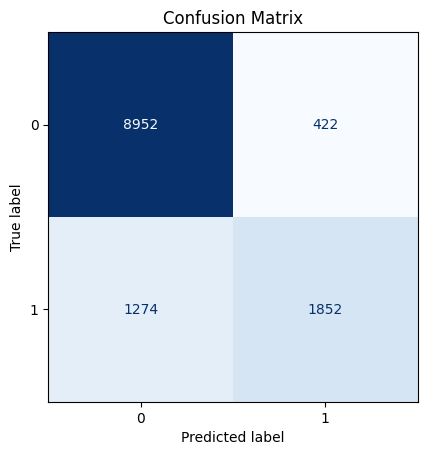


At fold 8 of run 0:


Overall Accuracy Scores for run 0: [np.float64(0.86432)]
Overall F1 Scores for run 0: [np.float64(0.799697656840514)]

=== Final Results for current run ===
Average Accuracy: 0.86432
Average F1-score: 0.799697656840514

Current Fold 1:
Fold scores for current sign fold 1 of run 1:

Fold Accuracy Scores: [0.8376]

Fold F1 Scores: [0.7566318422418068]

Fold 1 Accuracy: 0.838, F1: 0.757
  Class 0 -> Precision: 0.855, Recall: 0.943
  Class 1 -> Precision: 0.753, Recall: 0.522
Fold 1 Accuracy: 0.838, F1: 0.757


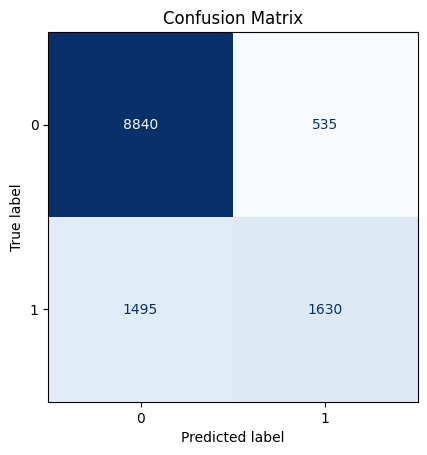


Current Fold 2:
Fold scores for current sign fold 2 of run 1:

Fold Accuracy Scores: [0.85288]

Fold F1 Scores: [0.784393766623311]

Fold 2 Accuracy: 0.853, F1: 0.784
  Class 0 -> Precision: 0.870, Recall: 0.944
  Class 1 -> Precision: 0.776, Recall: 0.578
Fold 2 Accuracy: 0.853, F1: 0.784


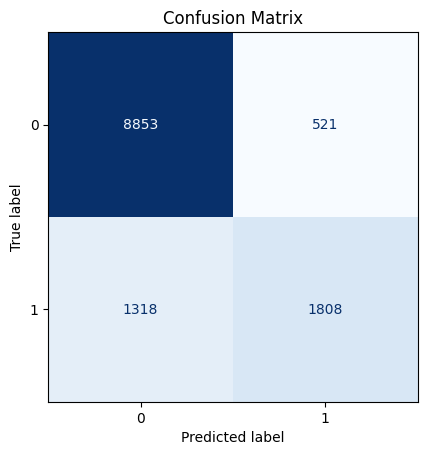


Current Fold 3:
Fold scores for current sign fold 3 of run 1:

Fold Accuracy Scores: [0.85936]

Fold F1 Scores: [0.7979316588042542]

Fold 3 Accuracy: 0.859, F1: 0.798
  Class 0 -> Precision: 0.880, Recall: 0.941
  Class 1 -> Precision: 0.776, Recall: 0.616
Fold 3 Accuracy: 0.859, F1: 0.798


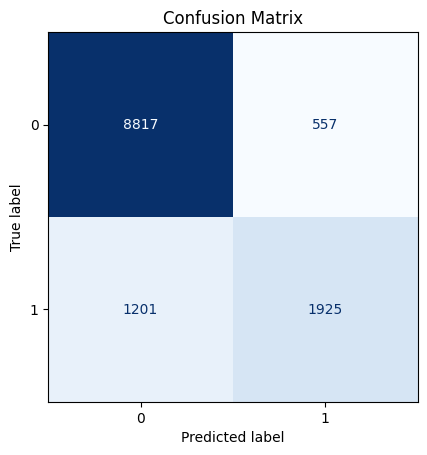


Current Fold 4:
Fold scores for current sign fold 4 of run 1:

Fold Accuracy Scores: [0.8556]

Fold F1 Scores: [0.7847639265466559]

Fold 4 Accuracy: 0.856, F1: 0.785
  Class 0 -> Precision: 0.868, Recall: 0.953
  Class 1 -> Precision: 0.800, Recall: 0.564
Fold 4 Accuracy: 0.856, F1: 0.785


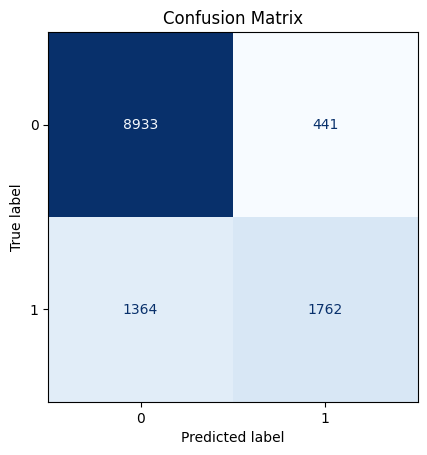


Current Fold 5:
Fold scores for current sign fold 5 of run 1:

Fold Accuracy Scores: [0.86592]

Fold F1 Scores: [0.8081815135029777]

Fold 5 Accuracy: 0.866, F1: 0.808
  Class 0 -> Precision: 0.886, Recall: 0.943
  Class 1 -> Precision: 0.788, Recall: 0.634
Fold 5 Accuracy: 0.866, F1: 0.808
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_5_run_1.pt with accuracy 0.808


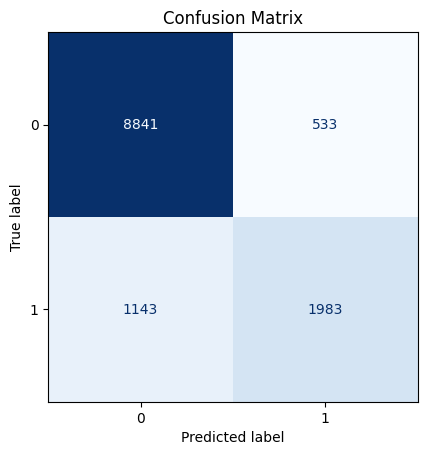


Current Fold 6:
Fold scores for current sign fold 6 of run 1:

Fold Accuracy Scores: [0.85512]

Fold F1 Scores: [0.7859146771421684]

Fold 6 Accuracy: 0.855, F1: 0.786
  Class 0 -> Precision: 0.870, Recall: 0.949
  Class 1 -> Precision: 0.790, Recall: 0.573
Fold 6 Accuracy: 0.855, F1: 0.786


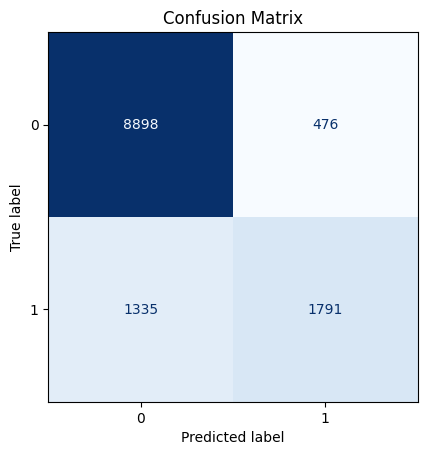


Current Fold 7:
Fold scores for current sign fold 7 of run 1:

Fold Accuracy Scores: [0.84224]

Fold F1 Scores: [0.763323213232362]

Fold 7 Accuracy: 0.842, F1: 0.763
  Class 0 -> Precision: 0.858, Recall: 0.947
  Class 1 -> Precision: 0.768, Recall: 0.529
Fold 7 Accuracy: 0.842, F1: 0.763


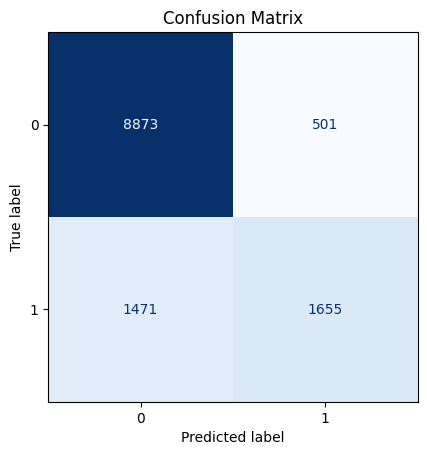


Current Fold 8:
Fold scores for current sign fold 8 of run 1:

Fold Accuracy Scores: [0.8436]

Fold F1 Scores: [0.7653960458911159]

Fold 8 Accuracy: 0.844, F1: 0.765
  Class 0 -> Precision: 0.859, Recall: 0.947
  Class 1 -> Precision: 0.771, Recall: 0.532
Fold 8 Accuracy: 0.844, F1: 0.765


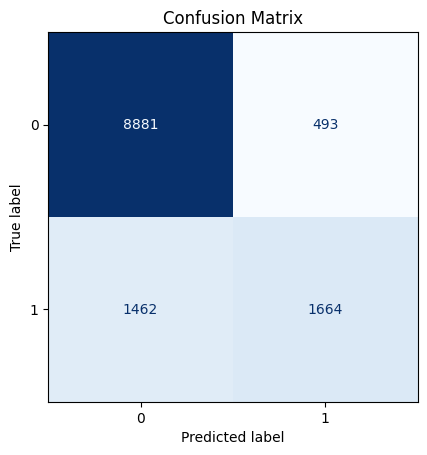


At fold 8 of run 1:


Overall Accuracy Scores for run 1: [np.float64(0.86432), np.float64(0.8436)]
Overall F1 Scores for run 1: [np.float64(0.799697656840514), np.float64(0.7653960458911159)]

=== Final Results for current run ===
Average Accuracy: 0.85396
Average F1-score: 0.7825468513658149

Current Fold 1:
Fold scores for current sign fold 1 of run 2:

Fold Accuracy Scores: [0.85904]

Fold F1 Scores: [0.7935576876211472]

Fold 1 Accuracy: 0.859, F1: 0.794
  Class 0 -> Precision: 0.874, Recall: 0.948
  Class 1 -> Precision: 0.792, Recall: 0.592
Fold 1 Accuracy: 0.859, F1: 0.794


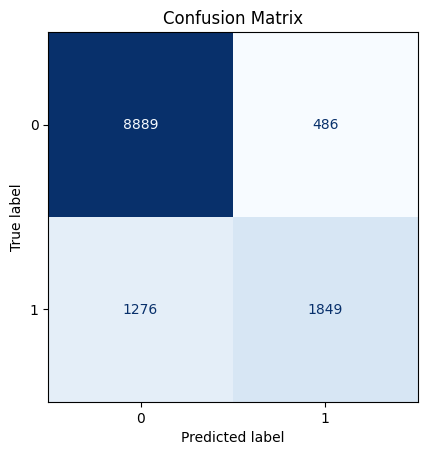


Current Fold 2:
Fold scores for current sign fold 2 of run 2:

Fold Accuracy Scores: [0.84312]

Fold F1 Scores: [0.7619558586482089]

Fold 2 Accuracy: 0.843, F1: 0.762
  Class 0 -> Precision: 0.856, Recall: 0.951
  Class 1 -> Precision: 0.781, Recall: 0.518
Fold 2 Accuracy: 0.843, F1: 0.762


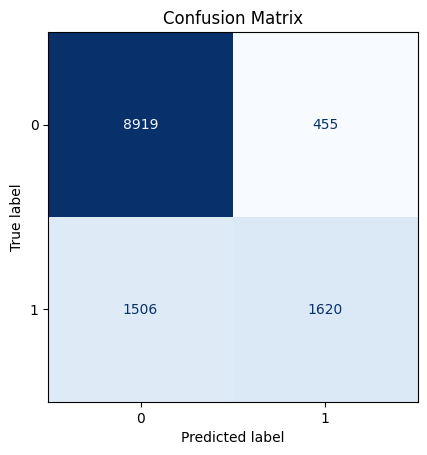


Current Fold 3:
Fold scores for current sign fold 3 of run 2:

Fold Accuracy Scores: [0.85304]

Fold F1 Scores: [0.7876360108693738]

Fold 3 Accuracy: 0.853, F1: 0.788
  Class 0 -> Precision: 0.874, Recall: 0.939
  Class 1 -> Precision: 0.764, Recall: 0.596
Fold 3 Accuracy: 0.853, F1: 0.788


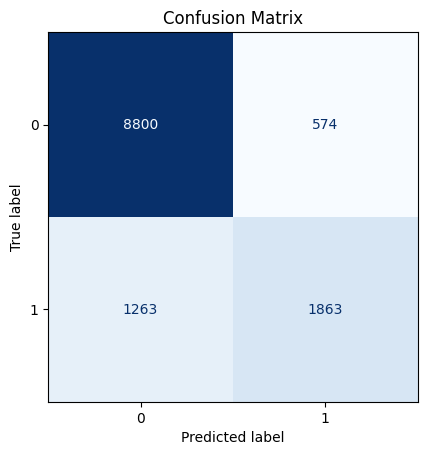


Current Fold 4:
Fold scores for current sign fold 4 of run 2:

Fold Accuracy Scores: [0.85336]

Fold F1 Scores: [0.786112194046971]

Fold 4 Accuracy: 0.853, F1: 0.786
  Class 0 -> Precision: 0.872, Recall: 0.943
  Class 1 -> Precision: 0.773, Recall: 0.585
Fold 4 Accuracy: 0.853, F1: 0.786


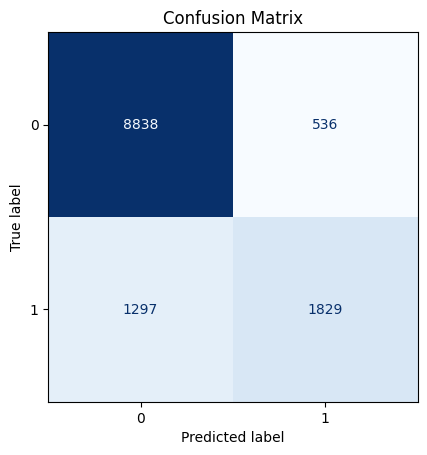


Current Fold 5:
Fold scores for current sign fold 5 of run 2:

Fold Accuracy Scores: [0.85272]

Fold F1 Scores: [0.7841022129408247]

Fold 5 Accuracy: 0.853, F1: 0.784
  Class 0 -> Precision: 0.870, Recall: 0.944
  Class 1 -> Precision: 0.776, Recall: 0.578
Fold 5 Accuracy: 0.853, F1: 0.784


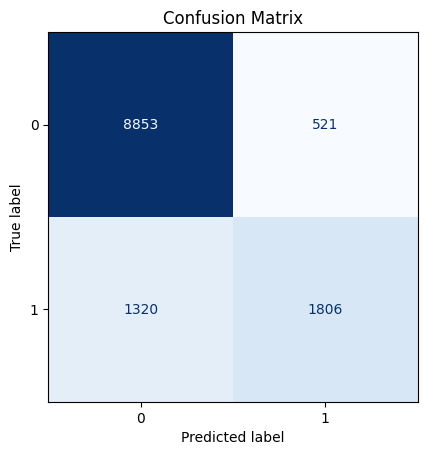


Current Fold 6:
Fold scores for current sign fold 6 of run 2:

Fold Accuracy Scores: [0.84912]

Fold F1 Scores: [0.7773178692534456]

Fold 6 Accuracy: 0.849, F1: 0.777
  Class 0 -> Precision: 0.866, Recall: 0.945
  Class 1 -> Precision: 0.772, Recall: 0.562
Fold 6 Accuracy: 0.849, F1: 0.777


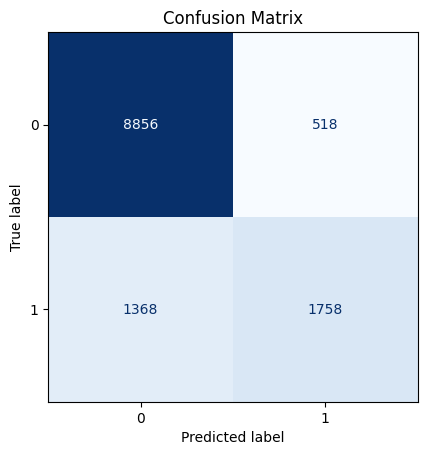


Current Fold 7:
Fold scores for current sign fold 7 of run 2:

Fold Accuracy Scores: [0.85648]

Fold F1 Scores: [0.7952412028498699]

Fold 7 Accuracy: 0.856, F1: 0.795
  Class 0 -> Precision: 0.880, Recall: 0.936
  Class 1 -> Precision: 0.762, Recall: 0.619
Fold 7 Accuracy: 0.856, F1: 0.795


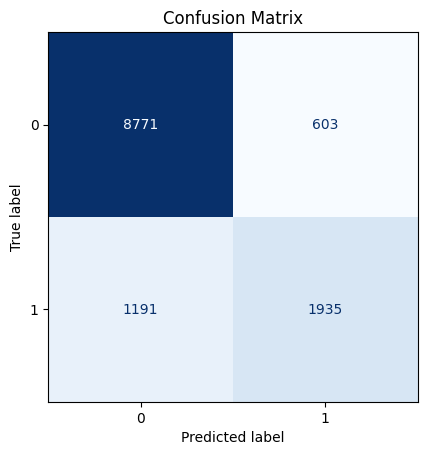


Current Fold 8:
Fold scores for current sign fold 8 of run 2:

Fold Accuracy Scores: [0.85008]

Fold F1 Scores: [0.7789125225608327]

Fold 8 Accuracy: 0.850, F1: 0.779
  Class 0 -> Precision: 0.867, Recall: 0.945
  Class 1 -> Precision: 0.774, Recall: 0.565
Fold 8 Accuracy: 0.850, F1: 0.779


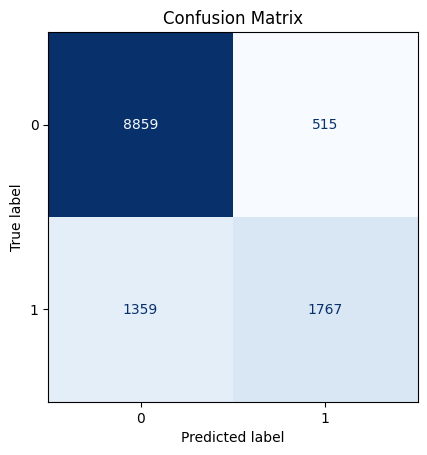


At fold 8 of run 2:


Overall Accuracy Scores for run 2: [np.float64(0.86432), np.float64(0.8436), np.float64(0.85008)]
Overall F1 Scores for run 2: [np.float64(0.799697656840514), np.float64(0.7653960458911159), np.float64(0.7789125225608327)]

=== Final Results for current run ===
Average Accuracy: 0.8526666666666666
Average F1-score: 0.7813354084308207

Current Fold 1:
Fold scores for current sign fold 1 of run 3:

Fold Accuracy Scores: [0.84072]

Fold F1 Scores: [0.7622589801601382]

Fold 1 Accuracy: 0.841, F1: 0.762
  Class 0 -> Precision: 0.858, Recall: 0.943
  Class 1 -> Precision: 0.758, Recall: 0.532
Fold 1 Accuracy: 0.841, F1: 0.762


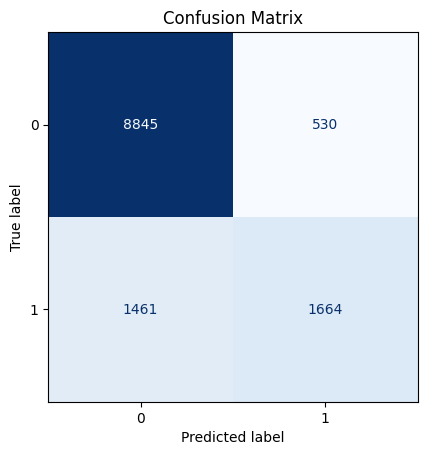


Current Fold 2:
Fold scores for current sign fold 2 of run 3:

Fold Accuracy Scores: [0.86568]

Fold F1 Scores: [0.8077173809864038]

Fold 2 Accuracy: 0.866, F1: 0.808
  Class 0 -> Precision: 0.885, Recall: 0.943
  Class 1 -> Precision: 0.788, Recall: 0.633
Fold 2 Accuracy: 0.866, F1: 0.808


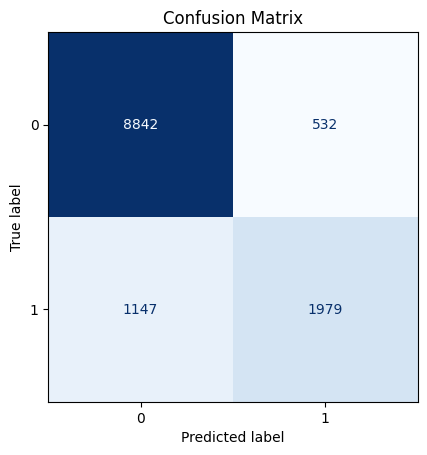


Current Fold 3:
Fold scores for current sign fold 3 of run 3:

Fold Accuracy Scores: [0.84672]

Fold F1 Scores: [0.7731053586924805]

Fold 3 Accuracy: 0.847, F1: 0.773
  Class 0 -> Precision: 0.864, Recall: 0.944
  Class 1 -> Precision: 0.768, Recall: 0.554
Fold 3 Accuracy: 0.847, F1: 0.773


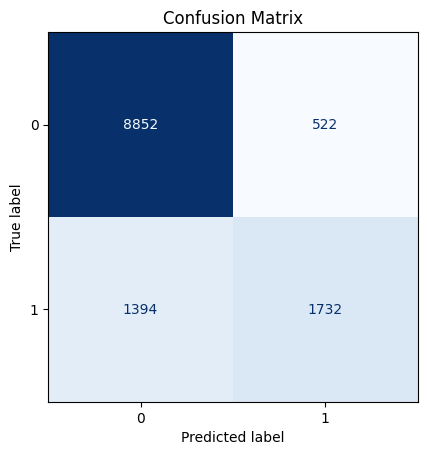


Current Fold 4:
Fold scores for current sign fold 4 of run 3:

Fold Accuracy Scores: [0.85112]

Fold F1 Scores: [0.7775988498182133]

Fold 4 Accuracy: 0.851, F1: 0.778
  Class 0 -> Precision: 0.864, Recall: 0.951
  Class 1 -> Precision: 0.789, Recall: 0.552
Fold 4 Accuracy: 0.851, F1: 0.778


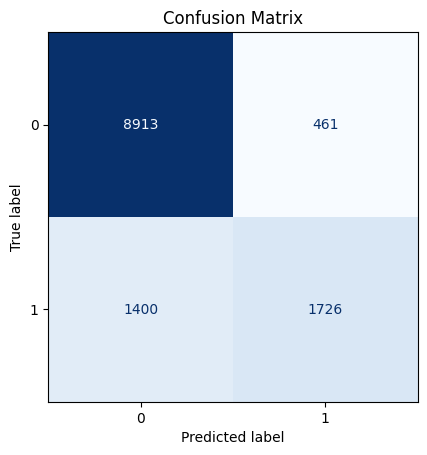


Current Fold 5:
Fold scores for current sign fold 5 of run 3:

Fold Accuracy Scores: [0.84216]

Fold F1 Scores: [0.7656905818463628]

Fold 5 Accuracy: 0.842, F1: 0.766
  Class 0 -> Precision: 0.860, Recall: 0.942
  Class 1 -> Precision: 0.758, Recall: 0.542
Fold 5 Accuracy: 0.842, F1: 0.766


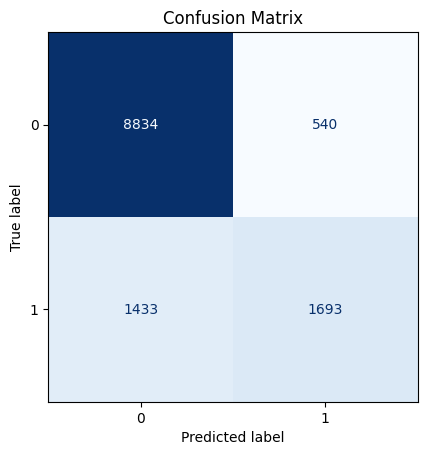


Current Fold 6:
Fold scores for current sign fold 6 of run 3:

Fold Accuracy Scores: [0.84504]

Fold F1 Scores: [0.7688971610263018]

Fold 6 Accuracy: 0.845, F1: 0.769
  Class 0 -> Precision: 0.861, Recall: 0.946
  Class 1 -> Precision: 0.770, Recall: 0.542
Fold 6 Accuracy: 0.845, F1: 0.769


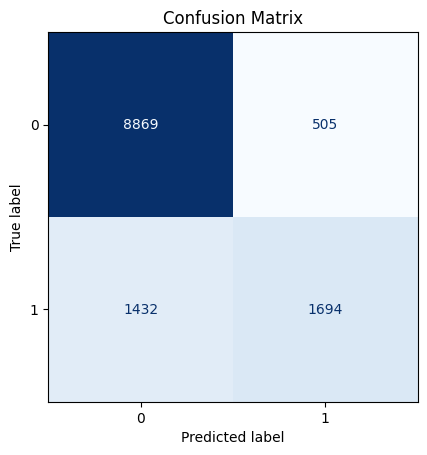


Current Fold 7:
Fold scores for current sign fold 7 of run 3:

Fold Accuracy Scores: [0.85376]

Fold F1 Scores: [0.7843971470600168]

Fold 7 Accuracy: 0.854, F1: 0.784
  Class 0 -> Precision: 0.869, Recall: 0.947
  Class 1 -> Precision: 0.784, Recall: 0.573
Fold 7 Accuracy: 0.854, F1: 0.784


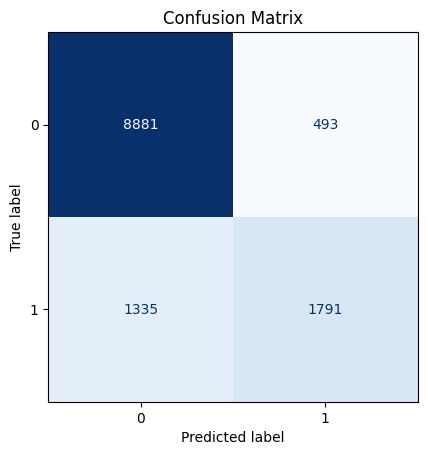


Current Fold 8:
Fold scores for current sign fold 8 of run 3:

Fold Accuracy Scores: [0.85016]

Fold F1 Scores: [0.7776870030699181]

Fold 8 Accuracy: 0.850, F1: 0.778
  Class 0 -> Precision: 0.865, Recall: 0.948
  Class 1 -> Precision: 0.780, Recall: 0.558
Fold 8 Accuracy: 0.850, F1: 0.778


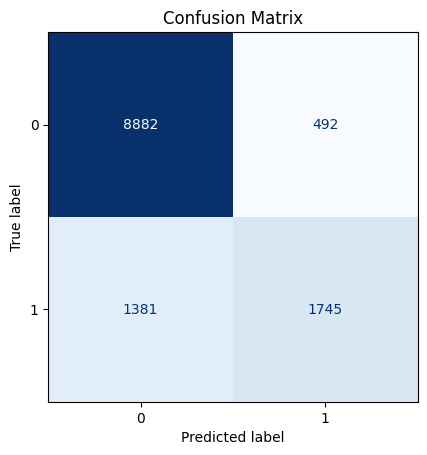


At fold 8 of run 3:


Overall Accuracy Scores for run 3: [np.float64(0.86432), np.float64(0.8436), np.float64(0.85008), np.float64(0.85016)]
Overall F1 Scores for run 3: [np.float64(0.799697656840514), np.float64(0.7653960458911159), np.float64(0.7789125225608327), np.float64(0.7776870030699181)]

=== Final Results for current run ===
Average Accuracy: 0.8520399999999999
Average F1-score: 0.780423307090595

Current Fold 1:
Fold scores for current sign fold 1 of run 4:

Fold Accuracy Scores: [0.85056]

Fold F1 Scores: [0.7822275198085289]

Fold 1 Accuracy: 0.851, F1: 0.782
  Class 0 -> Precision: 0.871, Recall: 0.940
  Class 1 -> Precision: 0.765, Recall: 0.581
Fold 1 Accuracy: 0.851, F1: 0.782


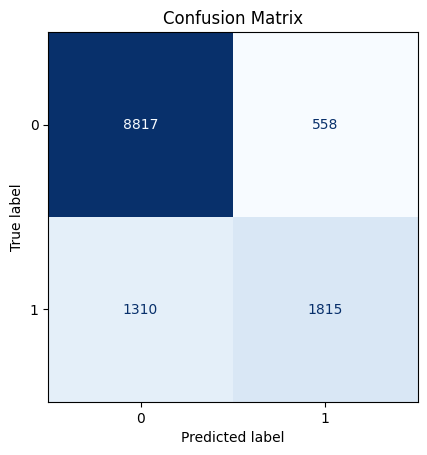


Current Fold 2:
Fold scores for current sign fold 2 of run 4:

Fold Accuracy Scores: [0.86256]

Fold F1 Scores: [0.7991893064242703]

Fold 2 Accuracy: 0.863, F1: 0.799
  Class 0 -> Precision: 0.877, Recall: 0.950
  Class 1 -> Precision: 0.799, Recall: 0.601
Fold 2 Accuracy: 0.863, F1: 0.799


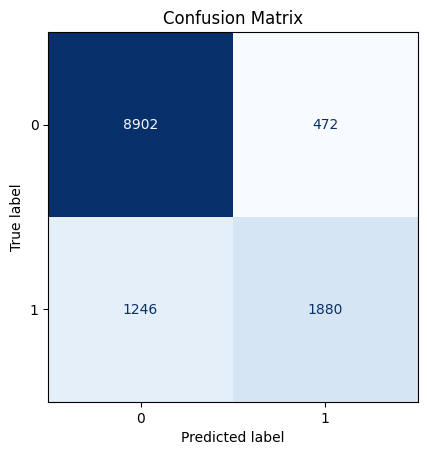


Current Fold 3:
Fold scores for current sign fold 3 of run 4:

Fold Accuracy Scores: [0.84224]

Fold F1 Scores: [0.7667254007629225]

Fold 3 Accuracy: 0.842, F1: 0.767
  Class 0 -> Precision: 0.861, Recall: 0.941
  Class 1 -> Precision: 0.755, Recall: 0.546
Fold 3 Accuracy: 0.842, F1: 0.767


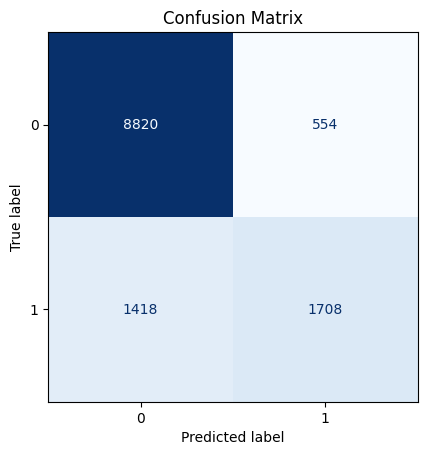


Current Fold 4:
Fold scores for current sign fold 4 of run 4:

Fold Accuracy Scores: [0.84856]

Fold F1 Scores: [0.7780627516138812]

Fold 4 Accuracy: 0.849, F1: 0.778
  Class 0 -> Precision: 0.868, Recall: 0.942
  Class 1 -> Precision: 0.765, Recall: 0.570
Fold 4 Accuracy: 0.849, F1: 0.778


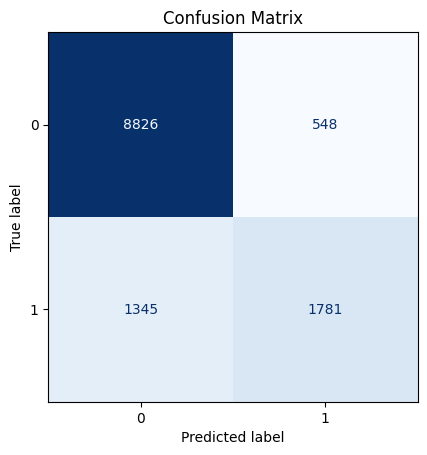


Current Fold 5:
Fold scores for current sign fold 5 of run 4:

Fold Accuracy Scores: [0.85688]

Fold F1 Scores: [0.7925450337767299]

Fold 5 Accuracy: 0.857, F1: 0.793
  Class 0 -> Precision: 0.876, Recall: 0.943
  Class 1 -> Precision: 0.777, Recall: 0.600
Fold 5 Accuracy: 0.857, F1: 0.793


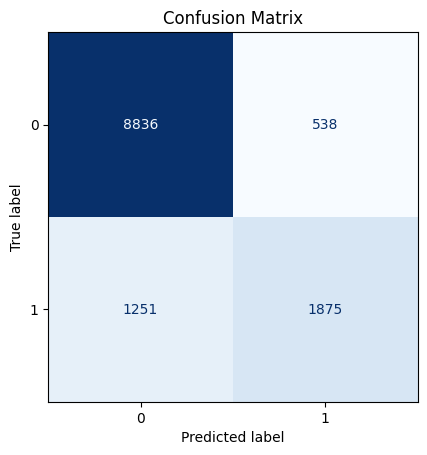


Current Fold 6:
Fold scores for current sign fold 6 of run 4:

Fold Accuracy Scores: [0.85984]

Fold F1 Scores: [0.7948916673981261]

Fold 6 Accuracy: 0.860, F1: 0.795
  Class 0 -> Precision: 0.875, Recall: 0.948
  Class 1 -> Precision: 0.794, Recall: 0.594
Fold 6 Accuracy: 0.860, F1: 0.795


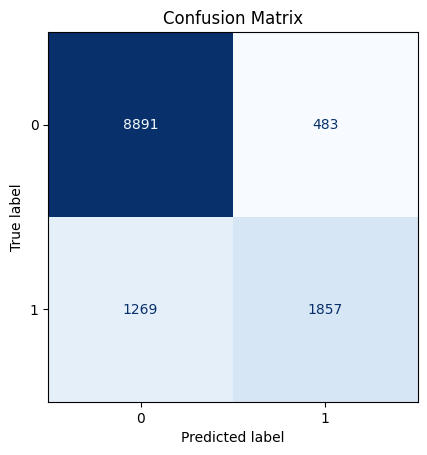


Current Fold 7:
Fold scores for current sign fold 7 of run 4:

Fold Accuracy Scores: [0.838]

Fold F1 Scores: [0.7568611011659631]

Fold 7 Accuracy: 0.838, F1: 0.757
  Class 0 -> Precision: 0.855, Recall: 0.944
  Class 1 -> Precision: 0.756, Recall: 0.520
Fold 7 Accuracy: 0.838, F1: 0.757


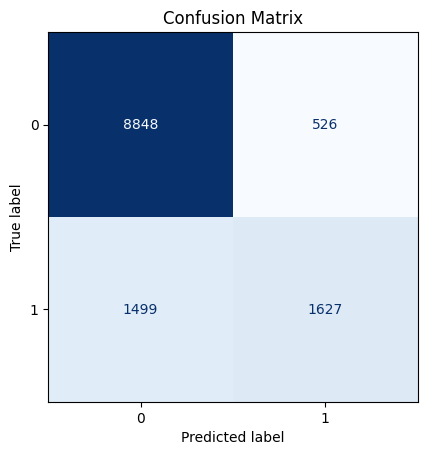


Current Fold 8:
Fold scores for current sign fold 8 of run 4:

Fold Accuracy Scores: [0.83736]

Fold F1 Scores: [0.7559005524298286]

Fold 8 Accuracy: 0.837, F1: 0.756
  Class 0 -> Precision: 0.855, Recall: 0.943
  Class 1 -> Precision: 0.754, Recall: 0.519
Fold 8 Accuracy: 0.837, F1: 0.756


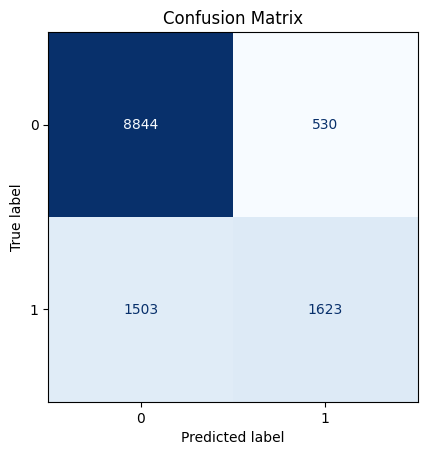


At fold 8 of run 4:


Overall Accuracy Scores for run 4: [np.float64(0.86432), np.float64(0.8436), np.float64(0.85008), np.float64(0.85016), np.float64(0.83736)]
Overall F1 Scores for run 4: [np.float64(0.799697656840514), np.float64(0.7653960458911159), np.float64(0.7789125225608327), np.float64(0.7776870030699181), np.float64(0.7559005524298286)]

=== Final Results for current run ===
Average Accuracy: 0.849104
Average F1-score: 0.7755187561584418

Current Fold 1:
Fold scores for current sign fold 1 of run 5:

Fold Accuracy Scores: [0.8572]

Fold F1 Scores: [0.7897779243671426]

Fold 1 Accuracy: 0.857, F1: 0.790
  Class 0 -> Precision: 0.872, Recall: 0.949
  Class 1 -> Precision: 0.792, Recall: 0.582
Fold 1 Accuracy: 0.857, F1: 0.790


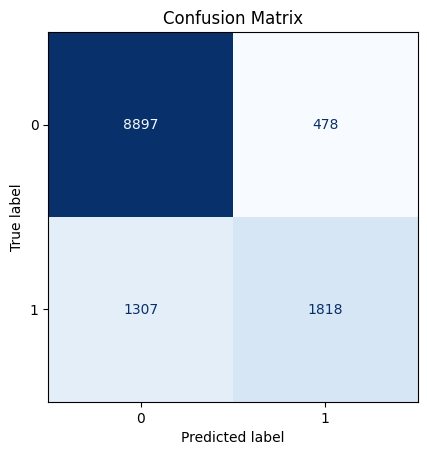


Current Fold 2:
Fold scores for current sign fold 2 of run 5:

Fold Accuracy Scores: [0.83696]

Fold F1 Scores: [0.752503614175878]

Fold 2 Accuracy: 0.837, F1: 0.753
  Class 0 -> Precision: 0.852, Recall: 0.948
  Class 1 -> Precision: 0.763, Recall: 0.505
Fold 2 Accuracy: 0.837, F1: 0.753


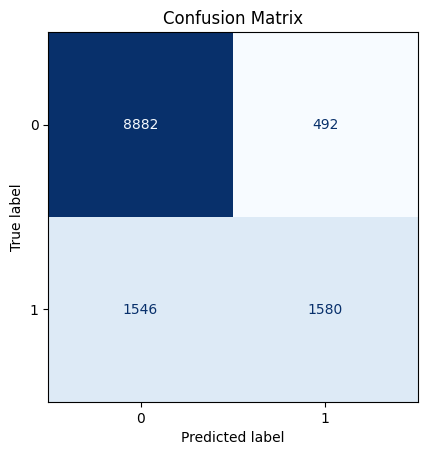


Current Fold 3:
Fold scores for current sign fold 3 of run 5:

Fold Accuracy Scores: [0.84576]

Fold F1 Scores: [0.773027414219808]

Fold 3 Accuracy: 0.846, F1: 0.773
  Class 0 -> Precision: 0.865, Recall: 0.941
  Class 1 -> Precision: 0.761, Recall: 0.559
Fold 3 Accuracy: 0.846, F1: 0.773


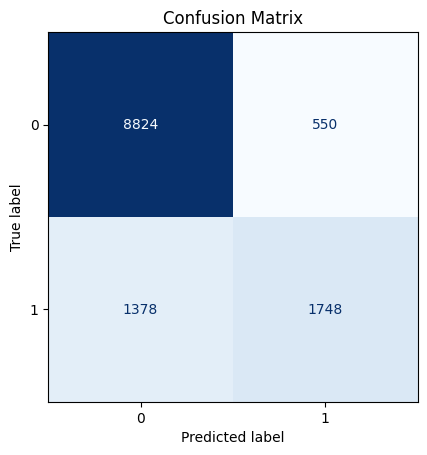


Current Fold 4:
Fold scores for current sign fold 4 of run 5:

Fold Accuracy Scores: [0.86224]

Fold F1 Scores: [0.8024198243053742]

Fold 4 Accuracy: 0.862, F1: 0.802
  Class 0 -> Precision: 0.882, Recall: 0.942
  Class 1 -> Precision: 0.781, Recall: 0.624
Fold 4 Accuracy: 0.862, F1: 0.802


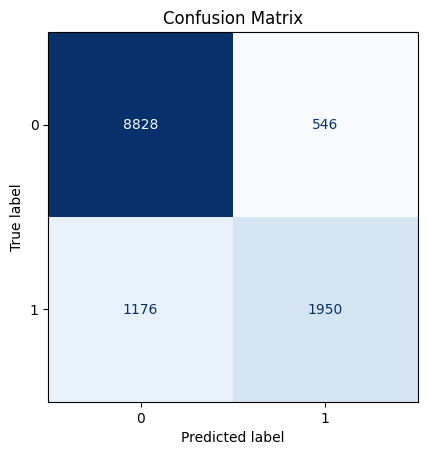


Current Fold 5:
Fold scores for current sign fold 5 of run 5:

Fold Accuracy Scores: [0.8556]

Fold F1 Scores: [0.7913353291340337]

Fold 5 Accuracy: 0.856, F1: 0.791
  Class 0 -> Precision: 0.876, Recall: 0.940
  Class 1 -> Precision: 0.771, Recall: 0.601
Fold 5 Accuracy: 0.856, F1: 0.791


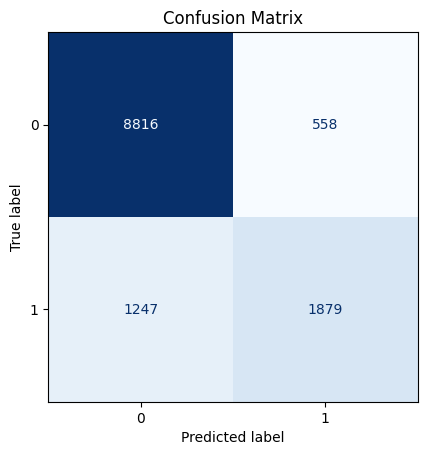


Current Fold 6:
Fold scores for current sign fold 6 of run 5:

Fold Accuracy Scores: [0.858]

Fold F1 Scores: [0.7944867313177371]

Fold 6 Accuracy: 0.858, F1: 0.794
  Class 0 -> Precision: 0.877, Recall: 0.943
  Class 1 -> Precision: 0.779, Recall: 0.604
Fold 6 Accuracy: 0.858, F1: 0.794


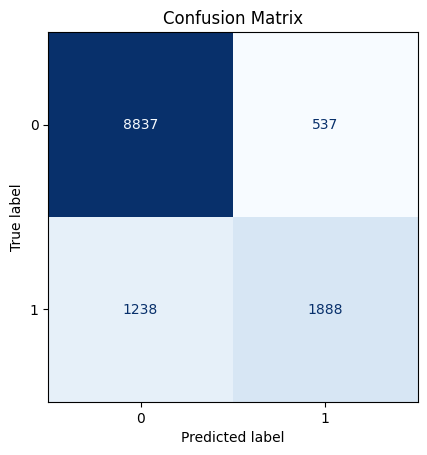


Current Fold 7:
Fold scores for current sign fold 7 of run 5:

Fold Accuracy Scores: [0.84]

Fold F1 Scores: [0.7609546271228759]

Fold 7 Accuracy: 0.840, F1: 0.761
  Class 0 -> Precision: 0.857, Recall: 0.943
  Class 1 -> Precision: 0.758, Recall: 0.530
Fold 7 Accuracy: 0.840, F1: 0.761


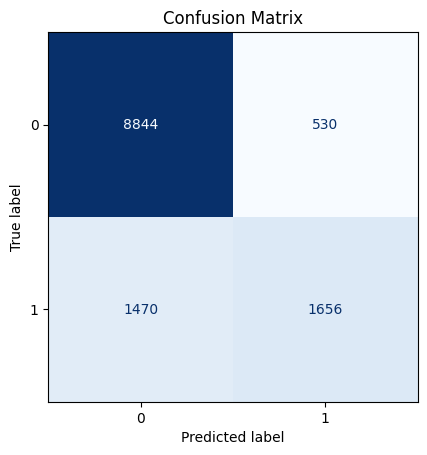


Current Fold 8:
Fold scores for current sign fold 8 of run 5:

Fold Accuracy Scores: [0.8644]

Fold F1 Scores: [0.8017995895672917]

Fold 8 Accuracy: 0.864, F1: 0.802
  Class 0 -> Precision: 0.878, Recall: 0.951
  Class 1 -> Precision: 0.805, Recall: 0.605
Fold 8 Accuracy: 0.864, F1: 0.802


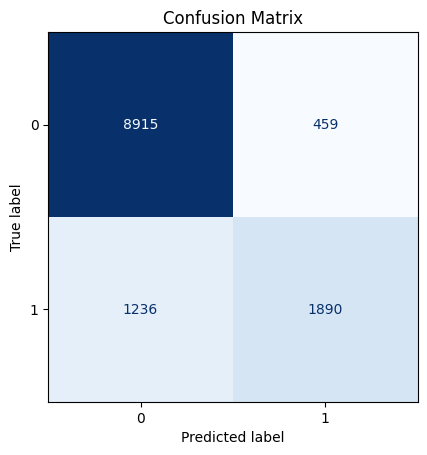


At fold 8 of run 5:


Overall Accuracy Scores for run 5: [np.float64(0.86432), np.float64(0.8436), np.float64(0.85008), np.float64(0.85016), np.float64(0.83736), np.float64(0.8644)]
Overall F1 Scores for run 5: [np.float64(0.799697656840514), np.float64(0.7653960458911159), np.float64(0.7789125225608327), np.float64(0.7776870030699181), np.float64(0.7559005524298286), np.float64(0.8017995895672917)]

=== Final Results for current run ===
Average Accuracy: 0.8516533333333333
Average F1-score: 0.7798988950599167

Current Fold 1:
Fold scores for current sign fold 1 of run 6:

Fold Accuracy Scores: [0.86016]

Fold F1 Scores: [0.7975867898747075]

Fold 1 Accuracy: 0.860, F1: 0.798
  Class 0 -> Precision: 0.879, Recall: 0.944
  Class 1 -> Precision: 0.784, Recall: 0.608
Fold 1 Accuracy: 0.860, F1: 0.798


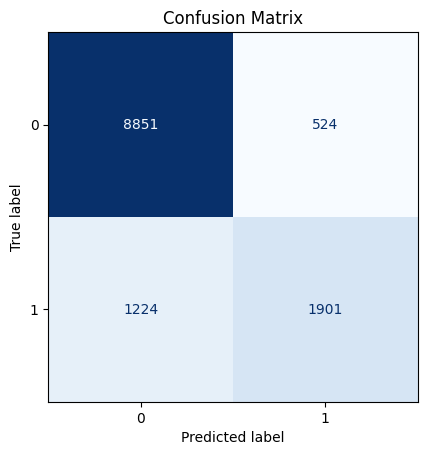


Current Fold 2:
Fold scores for current sign fold 2 of run 6:

Fold Accuracy Scores: [0.85128]

Fold F1 Scores: [0.7818759166784869]

Fold 2 Accuracy: 0.851, F1: 0.782
  Class 0 -> Precision: 0.869, Recall: 0.944
  Class 1 -> Precision: 0.773, Recall: 0.574
Fold 2 Accuracy: 0.851, F1: 0.782


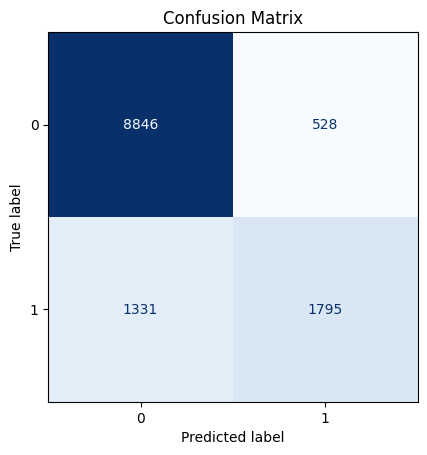


Current Fold 3:
Fold scores for current sign fold 3 of run 6:

Fold Accuracy Scores: [0.84384]

Fold F1 Scores: [0.7711152813156414]

Fold 3 Accuracy: 0.844, F1: 0.771
  Class 0 -> Precision: 0.865, Recall: 0.938
  Class 1 -> Precision: 0.752, Recall: 0.560
Fold 3 Accuracy: 0.844, F1: 0.771


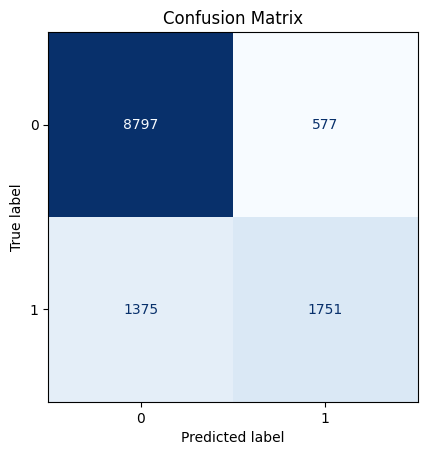


Current Fold 4:
Fold scores for current sign fold 4 of run 6:

Fold Accuracy Scores: [0.83904]

Fold F1 Scores: [0.7626953281645261]

Fold 4 Accuracy: 0.839, F1: 0.763
  Class 0 -> Precision: 0.860, Recall: 0.938
  Class 1 -> Precision: 0.744, Recall: 0.544
Fold 4 Accuracy: 0.839, F1: 0.763


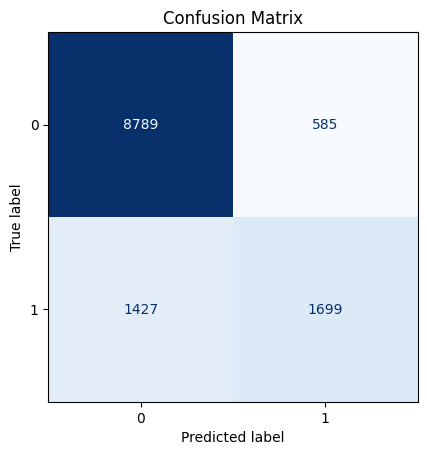


Current Fold 5:
Fold scores for current sign fold 5 of run 6:

Fold Accuracy Scores: [0.85464]

Fold F1 Scores: [0.7891346402222891]

Fold 5 Accuracy: 0.855, F1: 0.789
  Class 0 -> Precision: 0.874, Recall: 0.941
  Class 1 -> Precision: 0.772, Recall: 0.594
Fold 5 Accuracy: 0.855, F1: 0.789


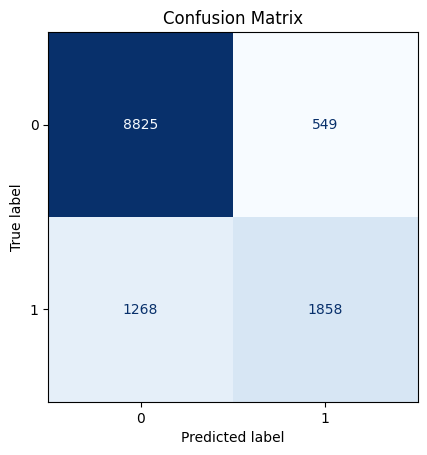


Current Fold 6:
Fold scores for current sign fold 6 of run 6:

Fold Accuracy Scores: [0.8612]

Fold F1 Scores: [0.8003474281558909]

Fold 6 Accuracy: 0.861, F1: 0.800
  Class 0 -> Precision: 0.881, Recall: 0.942
  Class 1 -> Precision: 0.781, Recall: 0.618
Fold 6 Accuracy: 0.861, F1: 0.800


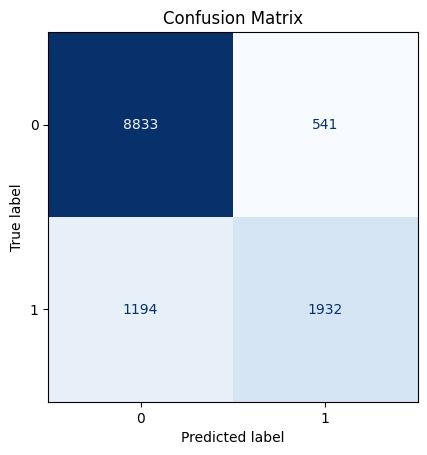


Current Fold 7:
Fold scores for current sign fold 7 of run 6:

Fold Accuracy Scores: [0.85424]

Fold F1 Scores: [0.7847589407875485]

Fold 7 Accuracy: 0.854, F1: 0.785
  Class 0 -> Precision: 0.869, Recall: 0.948
  Class 1 -> Precision: 0.787, Recall: 0.572
Fold 7 Accuracy: 0.854, F1: 0.785


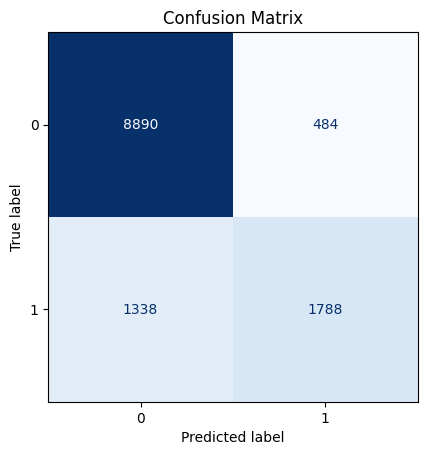


Current Fold 8:
Fold scores for current sign fold 8 of run 6:

Fold Accuracy Scores: [0.86232]

Fold F1 Scores: [0.8049551748685543]

Fold 8 Accuracy: 0.862, F1: 0.805
  Class 0 -> Precision: 0.886, Recall: 0.937
  Class 1 -> Precision: 0.771, Recall: 0.640
Fold 8 Accuracy: 0.862, F1: 0.805


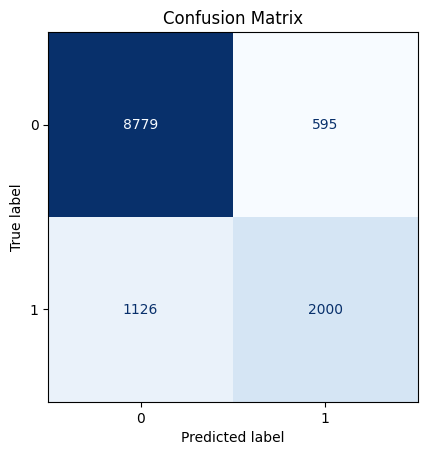


At fold 8 of run 6:


Overall Accuracy Scores for run 6: [np.float64(0.86432), np.float64(0.8436), np.float64(0.85008), np.float64(0.85016), np.float64(0.83736), np.float64(0.8644), np.float64(0.86232)]
Overall F1 Scores for run 6: [np.float64(0.799697656840514), np.float64(0.7653960458911159), np.float64(0.7789125225608327), np.float64(0.7776870030699181), np.float64(0.7559005524298286), np.float64(0.8017995895672917), np.float64(0.8049551748685543)]

=== Final Results for current run ===
Average Accuracy: 0.8531771428571427
Average F1-score: 0.7834783636040078

Current Fold 1:
Fold scores for current sign fold 1 of run 7:

Fold Accuracy Scores: [0.85432]

Fold F1 Scores: [0.7920816641293094]

Fold 1 Accuracy: 0.854, F1: 0.792
  Class 0 -> Precision: 0.879, Recall: 0.934
  Class 1 -> Precision: 0.757, Recall: 0.614
Fold 1 Accuracy: 0.854, F1: 0.792


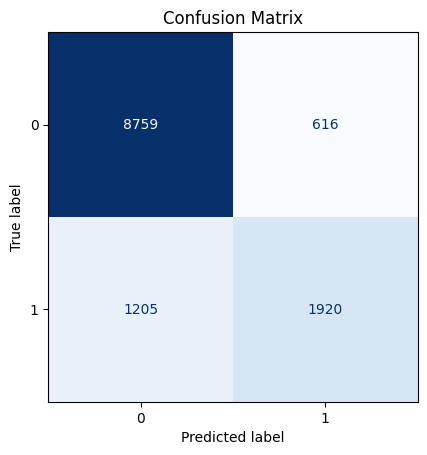


Current Fold 2:
Fold scores for current sign fold 2 of run 7:

Fold Accuracy Scores: [0.84224]

Fold F1 Scores: [0.7636505834771948]

Fold 2 Accuracy: 0.842, F1: 0.764
  Class 0 -> Precision: 0.858, Recall: 0.946
  Class 1 -> Precision: 0.766, Recall: 0.531
Fold 2 Accuracy: 0.842, F1: 0.764


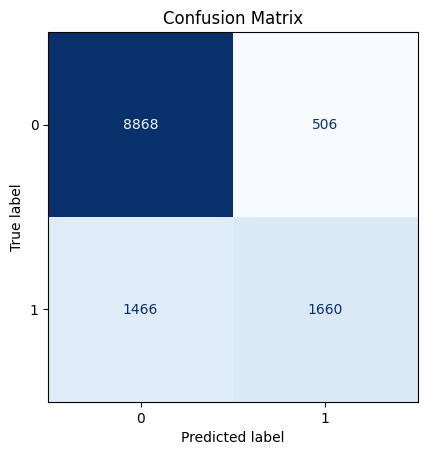


Current Fold 3:
Fold scores for current sign fold 3 of run 7:

Fold Accuracy Scores: [0.84568]

Fold F1 Scores: [0.7722102644222928]

Fold 3 Accuracy: 0.846, F1: 0.772
  Class 0 -> Precision: 0.864, Recall: 0.943
  Class 1 -> Precision: 0.763, Recall: 0.555
Fold 3 Accuracy: 0.846, F1: 0.772


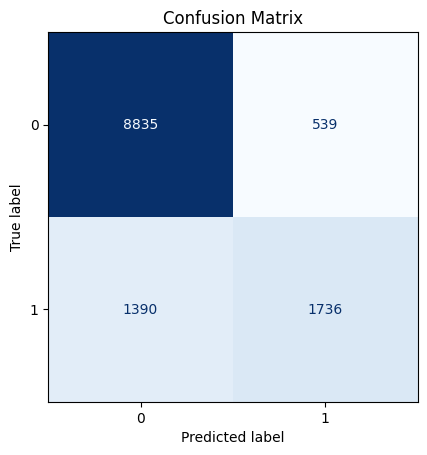


Current Fold 4:
Fold scores for current sign fold 4 of run 7:

Fold Accuracy Scores: [0.8564]

Fold F1 Scores: [0.7867137013454741]

Fold 4 Accuracy: 0.856, F1: 0.787
  Class 0 -> Precision: 0.869, Recall: 0.952
  Class 1 -> Precision: 0.799, Recall: 0.569
Fold 4 Accuracy: 0.856, F1: 0.787


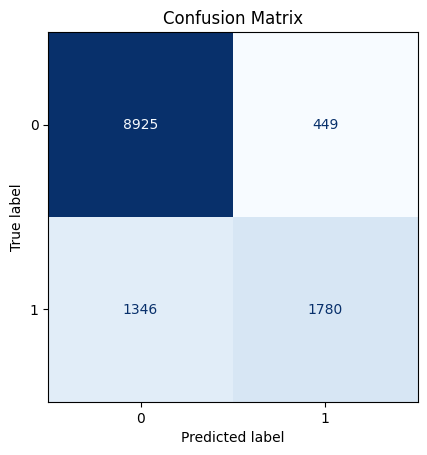


Current Fold 5:
Fold scores for current sign fold 5 of run 7:

Fold Accuracy Scores: [0.8532]

Fold F1 Scores: [0.7939494873827062]

Fold 5 Accuracy: 0.853, F1: 0.794
  Class 0 -> Precision: 0.884, Recall: 0.926
  Class 1 -> Precision: 0.742, Recall: 0.634
Fold 5 Accuracy: 0.853, F1: 0.794


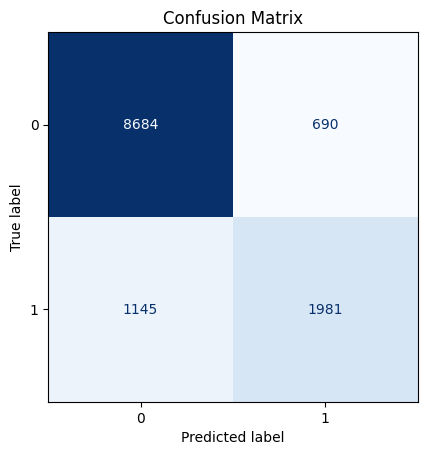


Current Fold 6:
Fold scores for current sign fold 6 of run 7:

Fold Accuracy Scores: [0.86552]

Fold F1 Scores: [0.8087817416280005]

Fold 6 Accuracy: 0.866, F1: 0.809
  Class 0 -> Precision: 0.887, Recall: 0.940
  Class 1 -> Precision: 0.782, Recall: 0.641
Fold 6 Accuracy: 0.866, F1: 0.809
Save current best performing model to saved_classifiers/sign_based\sign_based_fold_6_run_7.pt with accuracy 0.809


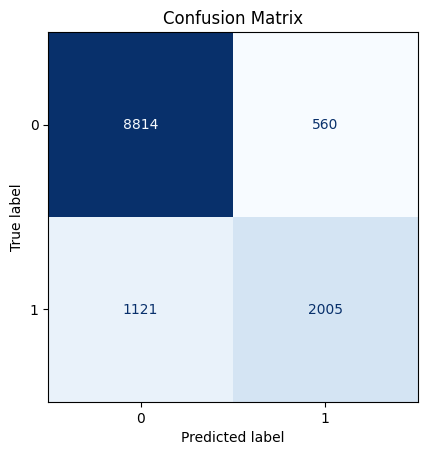


Current Fold 7:
Fold scores for current sign fold 7 of run 7:

Fold Accuracy Scores: [0.85512]

Fold F1 Scores: [0.7885686131065828]

Fold 7 Accuracy: 0.855, F1: 0.789
  Class 0 -> Precision: 0.873, Recall: 0.944
  Class 1 -> Precision: 0.778, Recall: 0.588
Fold 7 Accuracy: 0.855, F1: 0.789


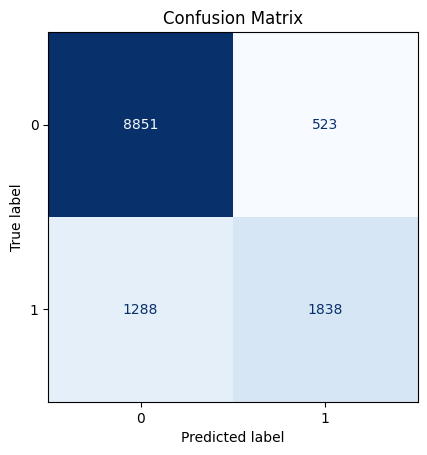


Current Fold 8:
Fold scores for current sign fold 8 of run 7:

Fold Accuracy Scores: [0.85712]

Fold F1 Scores: [0.7905798629250693]

Fold 8 Accuracy: 0.857, F1: 0.791
  Class 0 -> Precision: 0.873, Recall: 0.947
  Class 1 -> Precision: 0.788, Recall: 0.587
Fold 8 Accuracy: 0.857, F1: 0.791


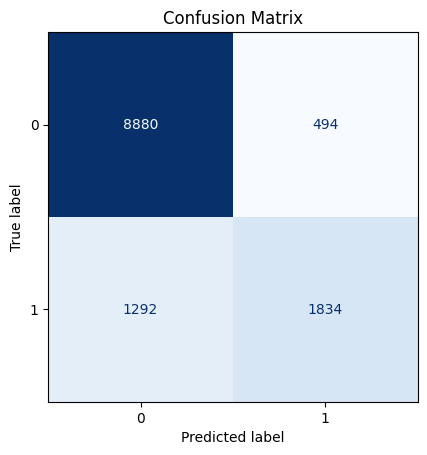


At fold 8 of run 7:


Overall Accuracy Scores for run 7: [np.float64(0.86432), np.float64(0.8436), np.float64(0.85008), np.float64(0.85016), np.float64(0.83736), np.float64(0.8644), np.float64(0.86232), np.float64(0.85712)]
Overall F1 Scores for run 7: [np.float64(0.799697656840514), np.float64(0.7653960458911159), np.float64(0.7789125225608327), np.float64(0.7776870030699181), np.float64(0.7559005524298286), np.float64(0.8017995895672917), np.float64(0.8049551748685543), np.float64(0.7905798629250693)]

=== Final Results for current run ===
Average Accuracy: 0.8536699999999999
Average F1-score: 0.7843660510191406

Current Fold 1:
Fold scores for current sign fold 1 of run 8:

Fold Accuracy Scores: [0.85736]

Fold F1 Scores: [0.7897327881345497]

Fold 1 Accuracy: 0.857, F1: 0.790
  Class 0 -> Precision: 0.872, Recall: 0.950
  Class 1 -> Precision: 0.794, Recall: 0.580
Fold 1 Accuracy: 0.857, F1: 0.790


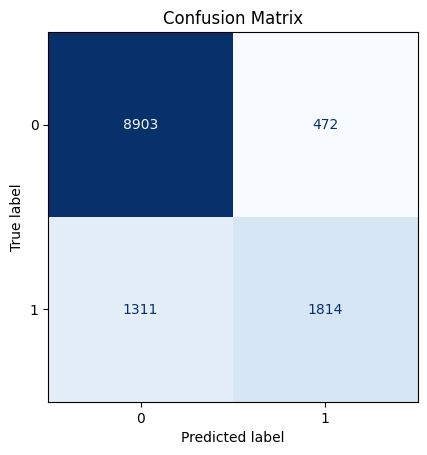


Current Fold 2:
Fold scores for current sign fold 2 of run 8:

Fold Accuracy Scores: [0.86424]

Fold F1 Scores: [0.8030608059753575]

Fold 2 Accuracy: 0.864, F1: 0.803
  Class 0 -> Precision: 0.880, Recall: 0.948
  Class 1 -> Precision: 0.797, Recall: 0.614
Fold 2 Accuracy: 0.864, F1: 0.803


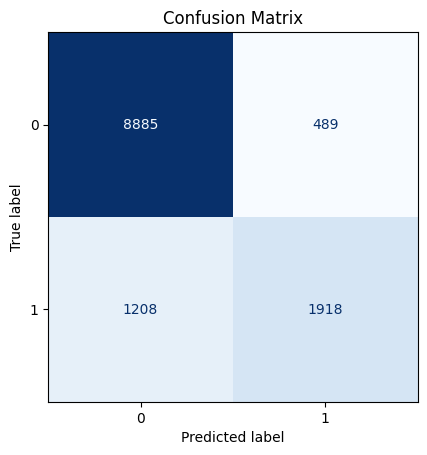


Current Fold 3:
Fold scores for current sign fold 3 of run 8:

Fold Accuracy Scores: [0.8492]

Fold F1 Scores: [0.7812997224072763]

Fold 3 Accuracy: 0.849, F1: 0.781
  Class 0 -> Precision: 0.871, Recall: 0.938
  Class 1 -> Precision: 0.758, Recall: 0.584
Fold 3 Accuracy: 0.849, F1: 0.781


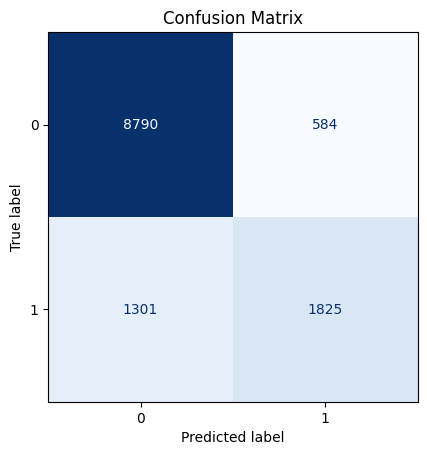


Current Fold 4:
Fold scores for current sign fold 4 of run 8:

Fold Accuracy Scores: [0.85992]

Fold F1 Scores: [0.7966361146516481]

Fold 4 Accuracy: 0.860, F1: 0.797
  Class 0 -> Precision: 0.877, Recall: 0.945
  Class 1 -> Precision: 0.786, Recall: 0.604
Fold 4 Accuracy: 0.860, F1: 0.797


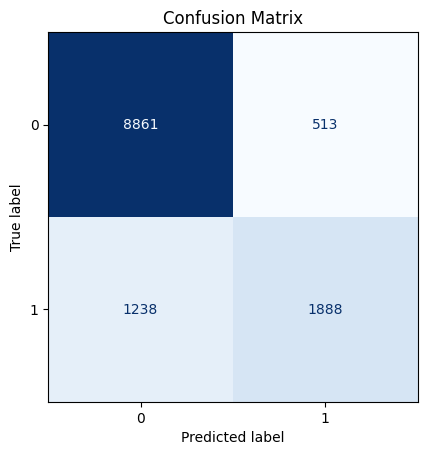


Current Fold 5:
Fold scores for current sign fold 5 of run 8:

Fold Accuracy Scores: [0.85488]

Fold F1 Scores: [0.7879682199380829]

Fold 5 Accuracy: 0.855, F1: 0.788
  Class 0 -> Precision: 0.872, Recall: 0.945
  Class 1 -> Precision: 0.779, Recall: 0.586
Fold 5 Accuracy: 0.855, F1: 0.788


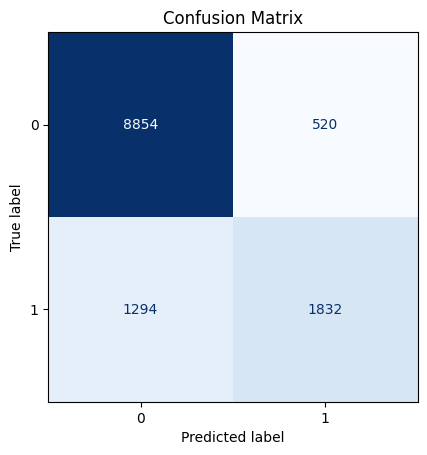


Current Fold 6:
Fold scores for current sign fold 6 of run 8:

Fold Accuracy Scores: [0.86128]

Fold F1 Scores: [0.8033609518886711]

Fold 6 Accuracy: 0.861, F1: 0.803
  Class 0 -> Precision: 0.885, Recall: 0.936
  Class 1 -> Precision: 0.769, Recall: 0.637
Fold 6 Accuracy: 0.861, F1: 0.803


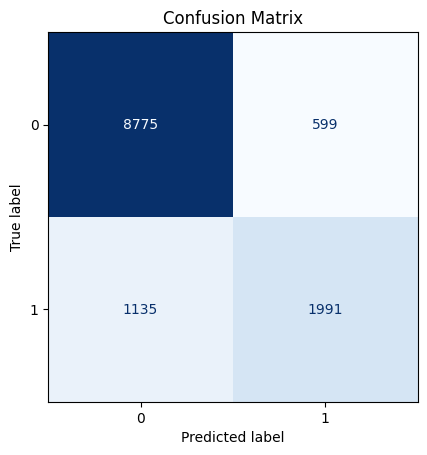


Current Fold 7:
Fold scores for current sign fold 7 of run 8:

Fold Accuracy Scores: [0.86016]

Fold F1 Scores: [0.7942178008590376]

Fold 7 Accuracy: 0.860, F1: 0.794
  Class 0 -> Precision: 0.874, Recall: 0.951
  Class 1 -> Precision: 0.800, Recall: 0.588
Fold 7 Accuracy: 0.860, F1: 0.794


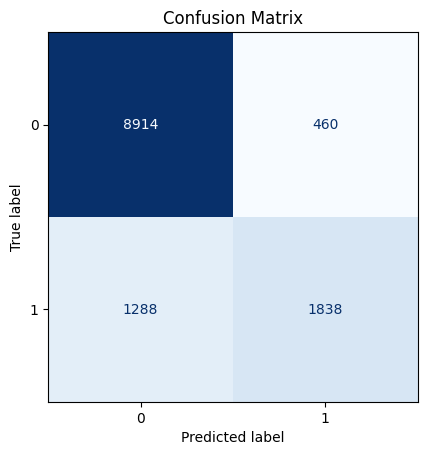


Current Fold 8:
Fold scores for current sign fold 8 of run 8:

Fold Accuracy Scores: [0.8512]

Fold F1 Scores: [0.7823626708453033]

Fold 8 Accuracy: 0.851, F1: 0.782
  Class 0 -> Precision: 0.870, Recall: 0.943
  Class 1 -> Precision: 0.770, Recall: 0.577
Fold 8 Accuracy: 0.851, F1: 0.782


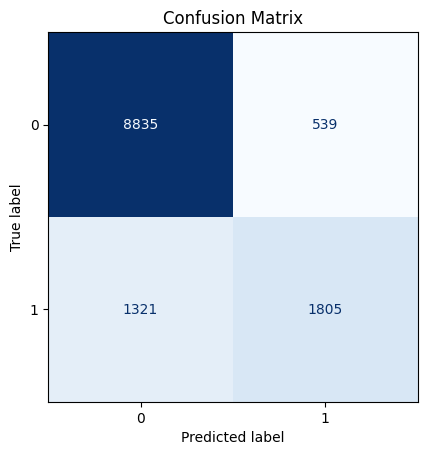


At fold 8 of run 8:


Overall Accuracy Scores for run 8: [np.float64(0.86432), np.float64(0.8436), np.float64(0.85008), np.float64(0.85016), np.float64(0.83736), np.float64(0.8644), np.float64(0.86232), np.float64(0.85712), np.float64(0.8512)]
Overall F1 Scores for run 8: [np.float64(0.799697656840514), np.float64(0.7653960458911159), np.float64(0.7789125225608327), np.float64(0.7776870030699181), np.float64(0.7559005524298286), np.float64(0.8017995895672917), np.float64(0.8049551748685543), np.float64(0.7905798629250693), np.float64(0.7823626708453033)]

=== Final Results for current run ===
Average Accuracy: 0.8533955555555556
Average F1-score: 0.7841434532220476

Current Fold 1:
Fold scores for current sign fold 1 of run 9:

Fold Accuracy Scores: [0.8596]

Fold F1 Scores: [0.7988618703802354]

Fold 1 Accuracy: 0.860, F1: 0.799
  Class 0 -> Precision: 0.881, Recall: 0.939
  Class 1 -> Precision: 0.773, Recall: 0.620
Fold 1 Accuracy: 0.860, F1: 0.799


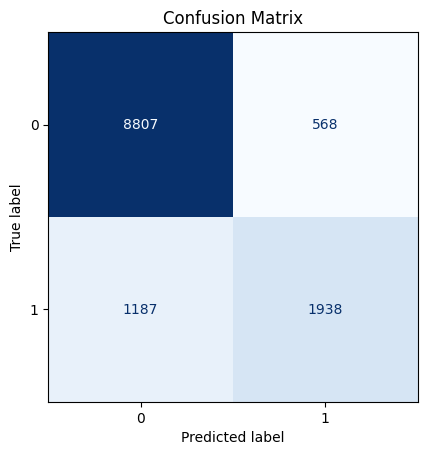


Current Fold 2:
Fold scores for current sign fold 2 of run 9:

Fold Accuracy Scores: [0.85896]

Fold F1 Scores: [0.797022178349232]

Fold 2 Accuracy: 0.859, F1: 0.797
  Class 0 -> Precision: 0.879, Recall: 0.941
  Class 1 -> Precision: 0.776, Recall: 0.613
Fold 2 Accuracy: 0.859, F1: 0.797


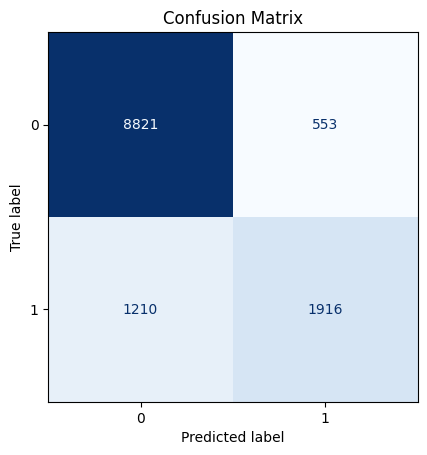


Current Fold 3:
Fold scores for current sign fold 3 of run 9:

Fold Accuracy Scores: [0.84824]

Fold F1 Scores: [0.7789909593531543]

Fold 3 Accuracy: 0.848, F1: 0.779
  Class 0 -> Precision: 0.869, Recall: 0.939
  Class 1 -> Precision: 0.759, Recall: 0.577
Fold 3 Accuracy: 0.848, F1: 0.779


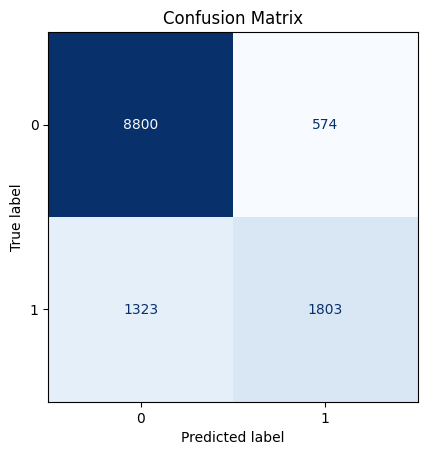


Current Fold 4:
Fold scores for current sign fold 4 of run 9:

Fold Accuracy Scores: [0.8344]

Fold F1 Scores: [0.747973070374685]

Fold 4 Accuracy: 0.834, F1: 0.748
  Class 0 -> Precision: 0.850, Recall: 0.947
  Class 1 -> Precision: 0.757, Recall: 0.497
Fold 4 Accuracy: 0.834, F1: 0.748


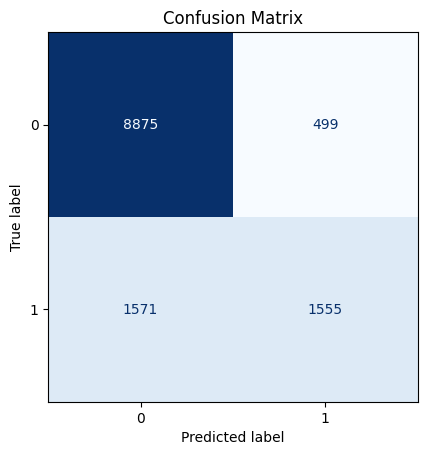


Current Fold 5:
Fold scores for current sign fold 5 of run 9:

Fold Accuracy Scores: [0.8428]

Fold F1 Scores: [0.7660047488389525]

Fold 5 Accuracy: 0.843, F1: 0.766
  Class 0 -> Precision: 0.860, Recall: 0.944
  Class 1 -> Precision: 0.762, Recall: 0.540
Fold 5 Accuracy: 0.843, F1: 0.766


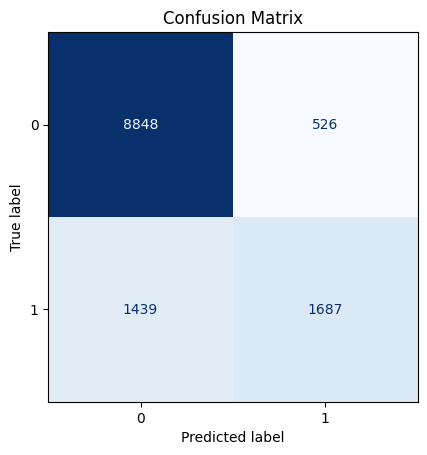


Current Fold 6:
Fold scores for current sign fold 6 of run 9:

Fold Accuracy Scores: [0.85432]

Fold F1 Scores: [0.7853089162063034]

Fold 6 Accuracy: 0.854, F1: 0.785
  Class 0 -> Precision: 0.870, Recall: 0.948
  Class 1 -> Precision: 0.785, Recall: 0.575
Fold 6 Accuracy: 0.854, F1: 0.785


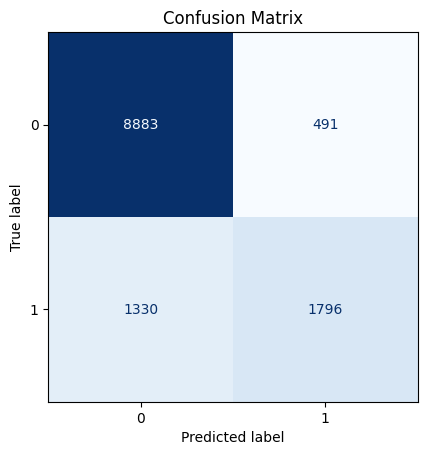


Current Fold 7:
Fold scores for current sign fold 7 of run 9:

Fold Accuracy Scores: [0.86288]

Fold F1 Scores: [0.7983279167553365]

Fold 7 Accuracy: 0.863, F1: 0.798
  Class 0 -> Precision: 0.876, Recall: 0.953
  Class 1 -> Precision: 0.807, Recall: 0.594
Fold 7 Accuracy: 0.863, F1: 0.798


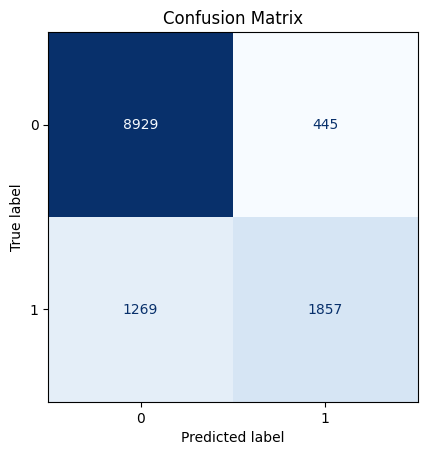


Current Fold 8:
Fold scores for current sign fold 8 of run 9:

Fold Accuracy Scores: [0.85192]

Fold F1 Scores: [0.7789154067138109]

Fold 8 Accuracy: 0.852, F1: 0.779
  Class 0 -> Precision: 0.865, Recall: 0.951
  Class 1 -> Precision: 0.791, Recall: 0.554
Fold 8 Accuracy: 0.852, F1: 0.779


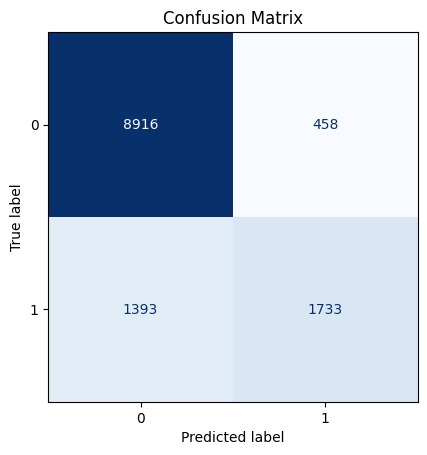


At fold 8 of run 9:


Overall Accuracy Scores for run 9: [np.float64(0.86432), np.float64(0.8436), np.float64(0.85008), np.float64(0.85016), np.float64(0.83736), np.float64(0.8644), np.float64(0.86232), np.float64(0.85712), np.float64(0.8512), np.float64(0.85192)]
Overall F1 Scores for run 9: [np.float64(0.799697656840514), np.float64(0.7653960458911159), np.float64(0.7789125225608327), np.float64(0.7776870030699181), np.float64(0.7559005524298286), np.float64(0.8017995895672917), np.float64(0.8049551748685543), np.float64(0.7905798629250693), np.float64(0.7823626708453033), np.float64(0.7789154067138109)]

=== Final Results for current run ===
Average Accuracy: 0.853248
Average F1-score: 0.7836206485712239


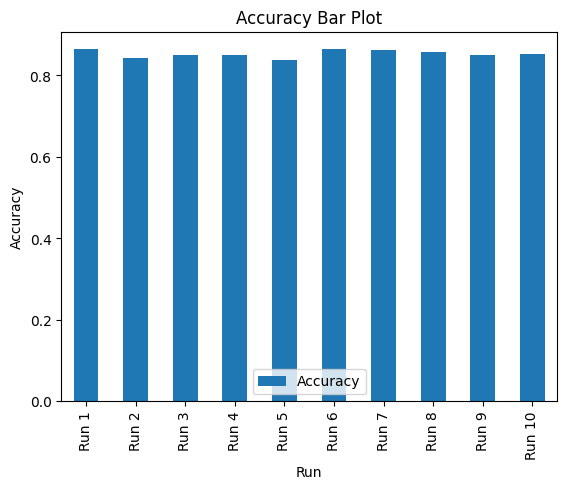

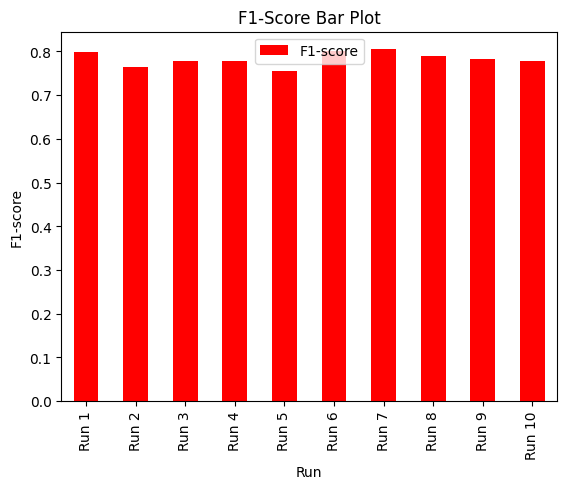

In [15]:
# Sign-Based Training.

accuracy_score_list = [] #For all independent runs
f1_score_list = [] #For all independent runs
epoch_count = 2
number_of_independent_runs_sign_based = 10
results_list_sign_based = []
save_dir = "saved_classifiers"
os.makedirs(save_dir, exist_ok=True)
fold_count = 2

current_best_performing_model = 0.0
overall_f1_list = []
overall_acc_list = []

# 1. Get Dataset Labels & Features
dataset_features = modified_dataframe.select_dtypes(include=[np.number])
dataset_labels = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

print("\nStarting Sign-Based model training:\n")

for run in range(number_of_independent_runs_sign_based):
    k_fold_sign_based = StratifiedKFold(n_splits=fold_count, shuffle=True)


    for fold, (train_index, test_index) in enumerate(k_fold_sign_based.split(dataset_features, dataset_labels), 1):
        print(f"\nCurrent Fold {fold}:")
        current_sign_fold_f1_scores = []
        current_sign_fold_acc_scores = []

        # 2. Split current folds into test and training set
        features_train, features_test = dataset_features.copy().iloc[train_index], dataset_features.copy().iloc[test_index]
        labels_train, labels_test =dataset_labels.copy().iloc[train_index], dataset_labels.copy().iloc[test_index]

        features_train_numpy = features_train.to_numpy()
        features_test_numpy = features_test.to_numpy()

        # 3. Normalize dataset
        standard_scaler = StandardScaler()
        features_train_scaled = standard_scaler.fit_transform(features_train_numpy)
        features_test_scaled = standard_scaler.transform(features_test_numpy)

        # 4. Convert to Tensors
        features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)
        features_test_tensor = torch.tensor(features_test_scaled, dtype=torch.float32)
        labels_train_tensor = torch.tensor(labels_train.to_numpy(), dtype=torch.long)
        labels_test_tensor = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

        # 5. Create Dataloaders
        training_dataset_converted = TensorDataset(features_train_tensor, labels_train_tensor)
        testing_dataset_converted = TensorDataset(features_test_tensor, labels_test_tensor)

        training_dataset_loader = DataLoader(training_dataset_converted, batch_size=64, shuffle=True)
        testing_dataset_loader = DataLoader(testing_dataset_converted, batch_size=64, shuffle=True)

        # 6. Compute class weights to address class imbalance
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train.to_numpy())
        class_weights = torch.tensor(class_weights, dtype=torch.float32)

        # 7. Redefine model in training loop.
        galaxy_classification_model = galaxy_classification_nn(dropout_rate=0.2).to(device)
        loss_function = nn.CrossEntropyLoss()
        error_optimizer = optim.Rprop(
            galaxy_classification_model.parameters(),
            lr=0.001,        # initial step size per weight
            etas=(0.5, 1.2),# (eta_minus, eta_plus)
            step_sizes=(1e-6, 50.0)  # (min_step, max_step)
        )

        # 8. Begin training loop for fold
        galaxy_classification_model.train()
        for epoch in range(epoch_count):
            for features, labels in training_dataset_loader:
                error_optimizer.zero_grad()
                outputs = galaxy_classification_model(features)
                loss = loss_function(outputs, labels)
                loss.backward()
                error_optimizer.step()

        # 9. Evaluation loop
        galaxy_classification_model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for features, labels in testing_dataset_loader:
                outputs = galaxy_classification_model(features)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())


        # Compute metrics

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average="macro")
        current_sign_fold_f1_scores.append(f1)
        current_sign_fold_acc_scores.append(acc)

        print(f"Fold scores for current sign fold {fold} of run {run}:\n")
        print(f"Fold Accuracy Scores: {current_sign_fold_acc_scores}\n")
        print(f"Fold F1 Scores: {current_sign_fold_f1_scores}\n")

        accuracy_score_list.append(acc)
        f1_score_list.append(f1)

        # Per-class precision and recall
        precision_per_class = precision_score(all_labels, all_preds, average=None)
        recall_per_class    = recall_score(all_labels, all_preds, average=None)

        print(f"Fold {fold} Accuracy: {acc:.3f}, F1: {f1:.3f}")
        for cls_idx, (prec, rec) in enumerate(zip(precision_per_class, recall_per_class)):
            print(f"  Class {cls_idx} -> Precision: {prec:.3f}, Recall: {rec:.3f}")

        print(f"Fold {fold} Accuracy: {acc:.3f}, F1: {f1:.3f}")

        # Evaluate if current model is best and save
        if f1 > current_best_performing_model:
            current_best_performing_model = f1
            file_save_path = os.path.join(save_dir, f"f1_score_{fold}.pt")
            torch.save(galaxy_classification_model.state_dict(), file_save_path)
            print(f"Save current best performing model to {file_save_path} with accuracy {f1:.3f}")

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', colorbar=False)
        plt.title("Confusion Matrix")
        plt.show()

        if fold >= fold_count:
            print(f"\nAt fold {fold} of run {run}:\n")
            overall_acc_list.append(np.mean(current_sign_fold_acc_scores))
            overall_f1_list.append(np.mean(current_sign_fold_f1_scores))
            print(f"\nOverall Accuracy Scores for run {run}: {overall_acc_list}")
            print(f"Overall F1 Scores for run {run}: {overall_f1_list}")


    # Average results across folds
    print("\n=== Final Results for current run ===")
    print("Average Accuracy:", np.mean(overall_acc_list))
    print("Average F1-score:", np.mean(overall_f1_list))

sign_acc_table = pd.DataFrame(overall_acc_list, columns=["Accuracy"])
sign_f1_table = pd.DataFrame(overall_f1_list, columns=["F1-Score"])
sign_plot_labels = [f"Run {i+1}" for i in range(len(overall_acc_list))]

sign_acc_table.plot(x='Accuracy', y='Value', kind='bar', title='Accuracy Bar Plot')
plt.ylabel('Value')
plt.show()




Starting Sign-Based model training:


Current Fold 1:
Fold scores for current sign fold 1 of run 0:

Fold Accuracy Scores: [0.80192]

Fold F1 Scores: [0.6686182535387502]

Fold 1 Accuracy: 0.802, F1: 0.669
  Class 0 -> Precision: 0.812, Recall: 0.957
  Class 1 -> Precision: 0.724, Recall: 0.335
Fold 1 Accuracy: 0.802, F1: 0.669
Save current best performing model to saved_classifiers/static_learning_rate\static_based_fold_1_run_0.pt with accuracy 0.669


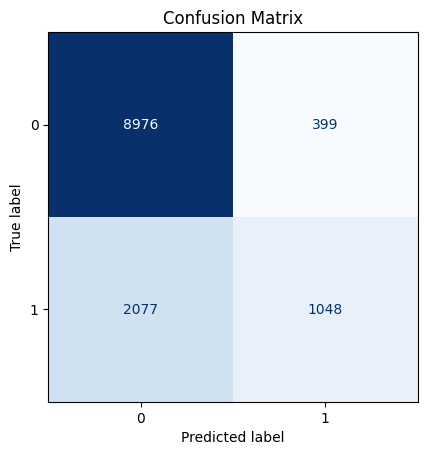


Current Fold 2:
Fold scores for current sign fold 2 of run 0:

Fold Accuracy Scores: [0.7976]

Fold F1 Scores: [0.6557464318675544]

Fold 2 Accuracy: 0.798, F1: 0.656
  Class 0 -> Precision: 0.807, Recall: 0.960
  Class 1 -> Precision: 0.721, Recall: 0.311
Fold 2 Accuracy: 0.798, F1: 0.656


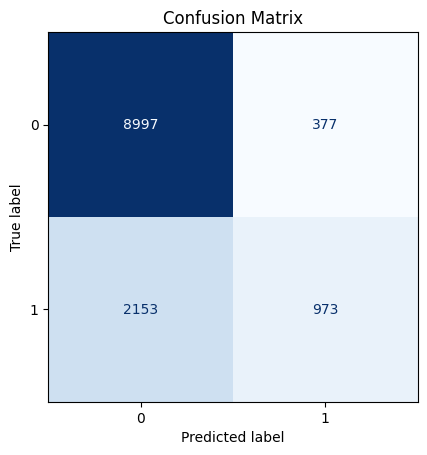


Current Fold 3:
Fold scores for current sign fold 3 of run 0:

Fold Accuracy Scores: [0.80264]

Fold F1 Scores: [0.6623683793696443]

Fold 3 Accuracy: 0.803, F1: 0.662
  Class 0 -> Precision: 0.809, Recall: 0.965
  Class 1 -> Precision: 0.750, Recall: 0.316
Fold 3 Accuracy: 0.803, F1: 0.662


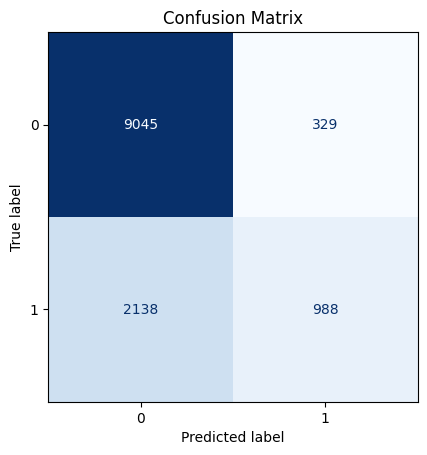


Current Fold 4:
Fold scores for current sign fold 4 of run 0:

Fold Accuracy Scores: [0.802]

Fold F1 Scores: [0.6649246357967713]

Fold 4 Accuracy: 0.802, F1: 0.665
  Class 0 -> Precision: 0.810, Recall: 0.961
  Class 1 -> Precision: 0.736, Recall: 0.325
Fold 4 Accuracy: 0.802, F1: 0.665


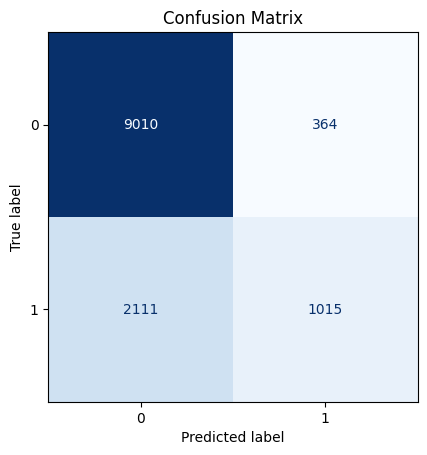


Current Fold 5:
Fold scores for current sign fold 5 of run 0:

Fold Accuracy Scores: [0.8072]

Fold F1 Scores: [0.6838436584694595]

Fold 5 Accuracy: 0.807, F1: 0.684
  Class 0 -> Precision: 0.818, Recall: 0.955
  Class 1 -> Precision: 0.729, Recall: 0.365
Fold 5 Accuracy: 0.807, F1: 0.684
Save current best performing model to saved_classifiers/static_learning_rate\static_based_fold_5_run_0.pt with accuracy 0.684


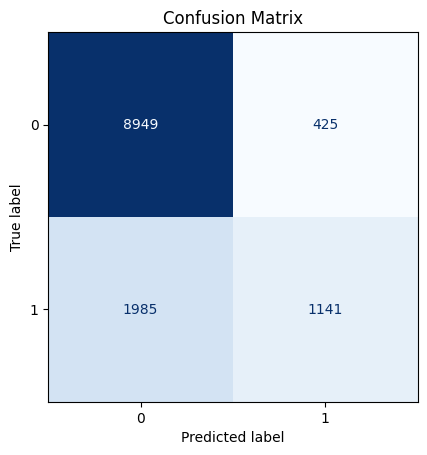


Current Fold 6:
Fold scores for current sign fold 6 of run 0:

Fold Accuracy Scores: [0.8448]

Fold F1 Scores: [0.7634633260860447]

Fold 6 Accuracy: 0.845, F1: 0.763
  Class 0 -> Precision: 0.855, Recall: 0.954
  Class 1 -> Precision: 0.790, Recall: 0.517
Fold 6 Accuracy: 0.845, F1: 0.763
Save current best performing model to saved_classifiers/static_learning_rate\static_based_fold_6_run_0.pt with accuracy 0.763


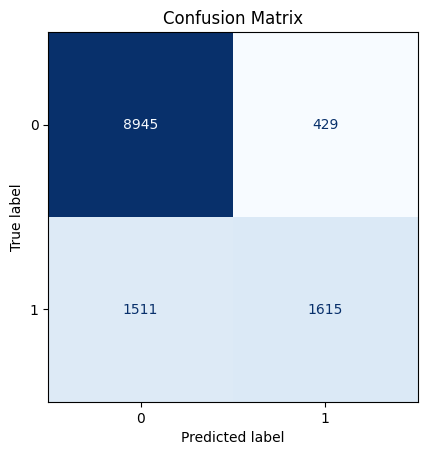


Current Fold 7:
Fold scores for current sign fold 7 of run 0:

Fold Accuracy Scores: [0.80672]

Fold F1 Scores: [0.6776324989138777]

Fold 7 Accuracy: 0.807, F1: 0.678
  Class 0 -> Precision: 0.815, Recall: 0.960
  Class 1 -> Precision: 0.742, Recall: 0.348
Fold 7 Accuracy: 0.807, F1: 0.678


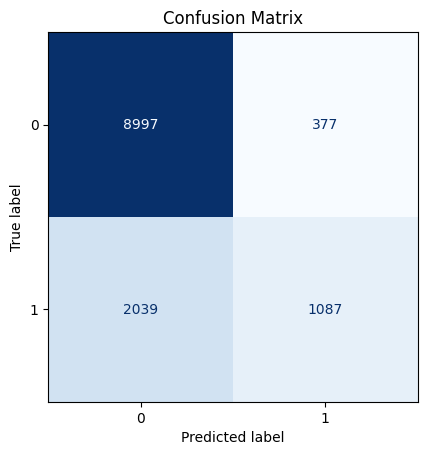


Current Fold 8:
Fold scores for current sign fold 8 of run 0:

Fold Accuracy Scores: [0.79776]

Fold F1 Scores: [0.6623460639979867]

Fold 8 Accuracy: 0.798, F1: 0.662
  Class 0 -> Precision: 0.810, Recall: 0.954
  Class 1 -> Precision: 0.705, Recall: 0.329
Fold 8 Accuracy: 0.798, F1: 0.662


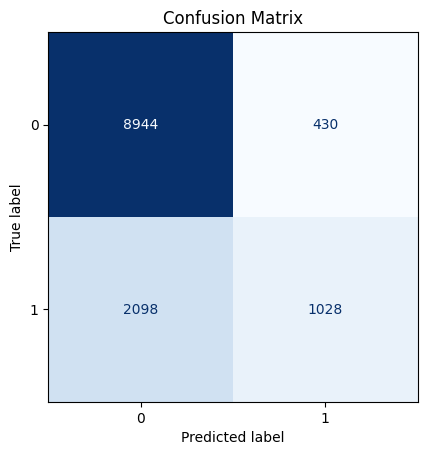


At fold 8 of run 0:


Overall Accuracy Scores for run 0: [np.float64(0.79776)]
Overall F1 Scores for run 0: [np.float64(0.6623460639979867)]

=== Final Results for current run ===
Average Accuracy: 0.79776
Average F1-score: 0.6623460639979867

Current Fold 1:
Fold scores for current sign fold 1 of run 1:

Fold Accuracy Scores: [0.84072]

Fold F1 Scores: [0.7487406264352765]

Fold 1 Accuracy: 0.841, F1: 0.749
  Class 0 -> Precision: 0.845, Recall: 0.964
  Class 1 -> Precision: 0.813, Recall: 0.471
Fold 1 Accuracy: 0.841, F1: 0.749


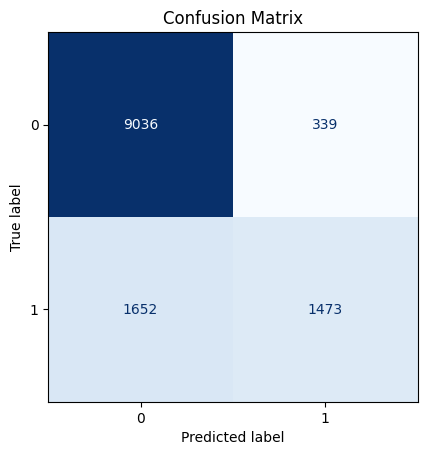


Current Fold 2:
Fold scores for current sign fold 2 of run 1:

Fold Accuracy Scores: [0.80128]

Fold F1 Scores: [0.6683351527010593]

Fold 2 Accuracy: 0.801, F1: 0.668
  Class 0 -> Precision: 0.812, Recall: 0.956
  Class 1 -> Precision: 0.720, Recall: 0.336
Fold 2 Accuracy: 0.801, F1: 0.668


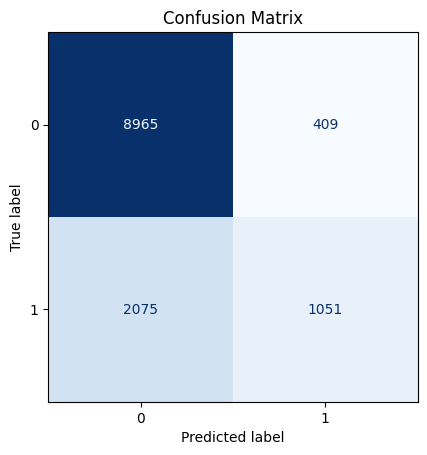


Current Fold 3:
Fold scores for current sign fold 3 of run 1:

Fold Accuracy Scores: [0.8072]

Fold F1 Scores: [0.680691765470439]

Fold 3 Accuracy: 0.807, F1: 0.681
  Class 0 -> Precision: 0.817, Recall: 0.958
  Class 1 -> Precision: 0.738, Recall: 0.355
Fold 3 Accuracy: 0.807, F1: 0.681


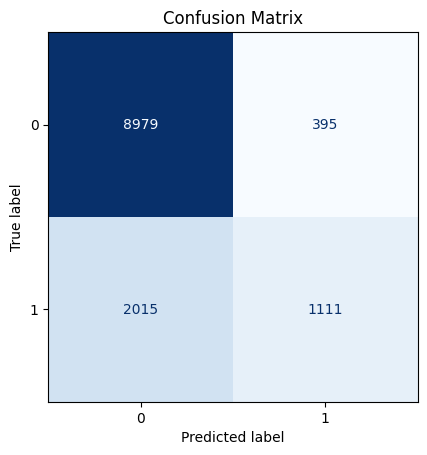


Current Fold 4:
Fold scores for current sign fold 4 of run 1:

Fold Accuracy Scores: [0.80184]

Fold F1 Scores: [0.6660398552485953]

Fold 4 Accuracy: 0.802, F1: 0.666
  Class 0 -> Precision: 0.811, Recall: 0.960
  Class 1 -> Precision: 0.731, Recall: 0.328
Fold 4 Accuracy: 0.802, F1: 0.666


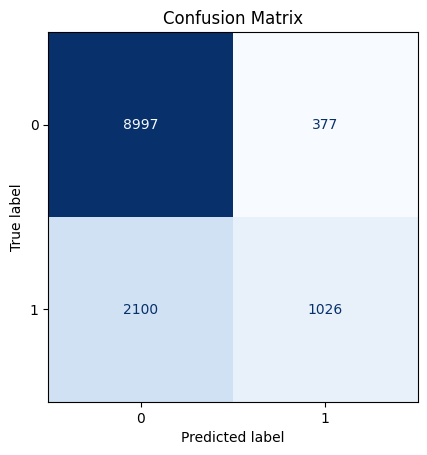


Current Fold 5:
Fold scores for current sign fold 5 of run 1:

Fold Accuracy Scores: [0.80632]

Fold F1 Scores: [0.6754831970748804]

Fold 5 Accuracy: 0.806, F1: 0.675
  Class 0 -> Precision: 0.814, Recall: 0.961
  Class 1 -> Precision: 0.745, Recall: 0.343
Fold 5 Accuracy: 0.806, F1: 0.675


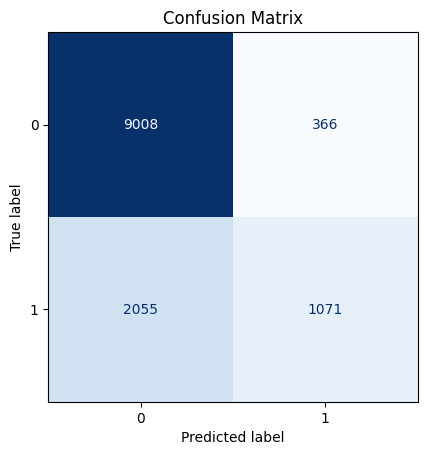


Current Fold 6:
Fold scores for current sign fold 6 of run 1:

Fold Accuracy Scores: [0.7972]

Fold F1 Scores: [0.6630610647338406]

Fold 6 Accuracy: 0.797, F1: 0.663
  Class 0 -> Precision: 0.810, Recall: 0.952
  Class 1 -> Precision: 0.699, Recall: 0.332
Fold 6 Accuracy: 0.797, F1: 0.663


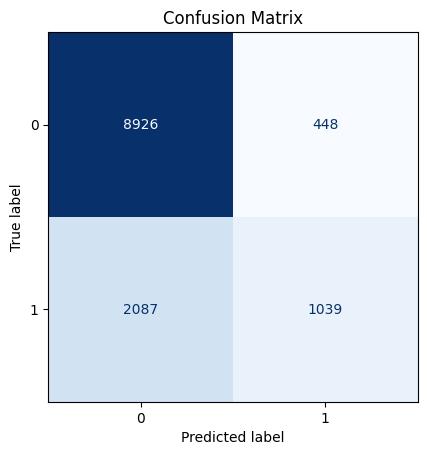


Current Fold 7:
Fold scores for current sign fold 7 of run 1:

Fold Accuracy Scores: [0.8068]

Fold F1 Scores: [0.6777115010867488]

Fold 7 Accuracy: 0.807, F1: 0.678
  Class 0 -> Precision: 0.815, Recall: 0.960
  Class 1 -> Precision: 0.743, Recall: 0.348
Fold 7 Accuracy: 0.807, F1: 0.678


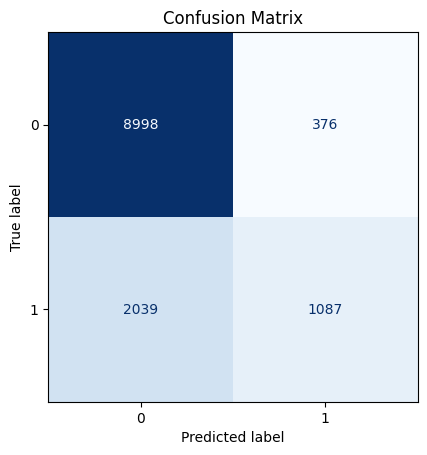


Current Fold 8:
Fold scores for current sign fold 8 of run 1:

Fold Accuracy Scores: [0.80736]

Fold F1 Scores: [0.6808502742461016]

Fold 8 Accuracy: 0.807, F1: 0.681
  Class 0 -> Precision: 0.817, Recall: 0.958
  Class 1 -> Precision: 0.739, Recall: 0.355
Fold 8 Accuracy: 0.807, F1: 0.681


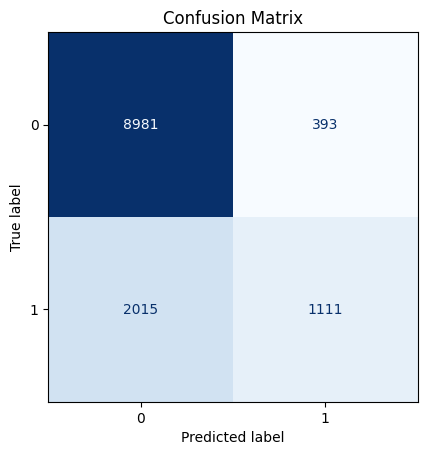


At fold 8 of run 1:


Overall Accuracy Scores for run 1: [np.float64(0.79776), np.float64(0.80736)]
Overall F1 Scores for run 1: [np.float64(0.6623460639979867), np.float64(0.6808502742461016)]

=== Final Results for current run ===
Average Accuracy: 0.8025599999999999
Average F1-score: 0.6715981691220441

Current Fold 1:
Fold scores for current sign fold 1 of run 2:

Fold Accuracy Scores: [0.80752]

Fold F1 Scores: [0.6802606954950214]

Fold 1 Accuracy: 0.808, F1: 0.680
  Class 0 -> Precision: 0.816, Recall: 0.959
  Class 1 -> Precision: 0.741, Recall: 0.353
Fold 1 Accuracy: 0.808, F1: 0.680


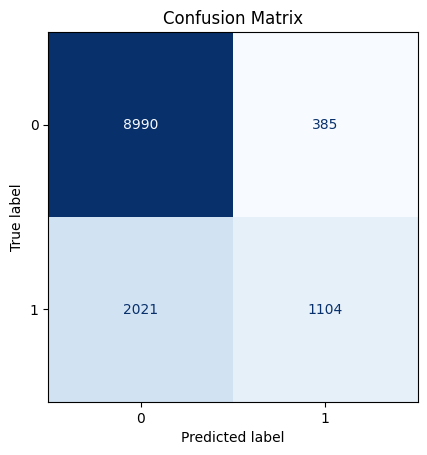


Current Fold 2:
Fold scores for current sign fold 2 of run 2:

Fold Accuracy Scores: [0.79888]

Fold F1 Scores: [0.6602913652583563]

Fold 2 Accuracy: 0.799, F1: 0.660
  Class 0 -> Precision: 0.809, Recall: 0.959
  Class 1 -> Precision: 0.720, Recall: 0.320
Fold 2 Accuracy: 0.799, F1: 0.660


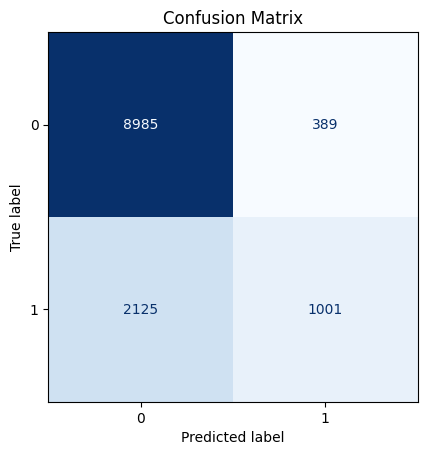


Current Fold 3:
Fold scores for current sign fold 3 of run 2:

Fold Accuracy Scores: [0.80392]

Fold F1 Scores: [0.6669029956616337]

Fold 3 Accuracy: 0.804, F1: 0.667
  Class 0 -> Precision: 0.811, Recall: 0.964
  Class 1 -> Precision: 0.749, Recall: 0.325
Fold 3 Accuracy: 0.804, F1: 0.667


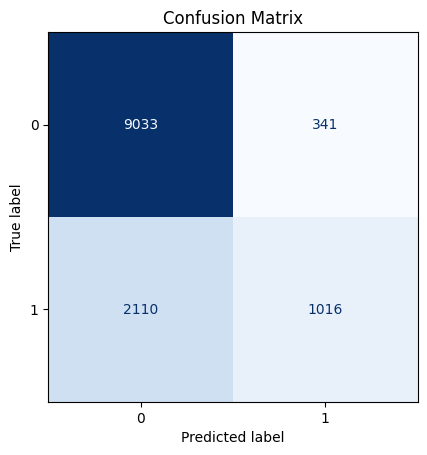


Current Fold 4:
Fold scores for current sign fold 4 of run 2:

Fold Accuracy Scores: [0.8496]

Fold F1 Scores: [0.7668125566695101]

Fold 4 Accuracy: 0.850, F1: 0.767
  Class 0 -> Precision: 0.854, Recall: 0.964
  Class 1 -> Precision: 0.823, Recall: 0.507
Fold 4 Accuracy: 0.850, F1: 0.767
Save current best performing model to saved_classifiers/static_learning_rate\static_based_fold_4_run_2.pt with accuracy 0.767


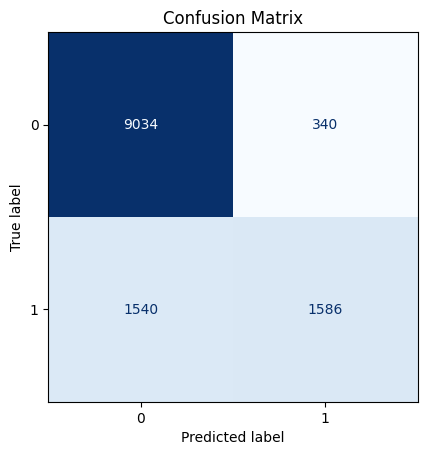


Current Fold 5:
Fold scores for current sign fold 5 of run 2:

Fold Accuracy Scores: [0.80688]

Fold F1 Scores: [0.6794125235290491]

Fold 5 Accuracy: 0.807, F1: 0.679
  Class 0 -> Precision: 0.816, Recall: 0.958
  Class 1 -> Precision: 0.739, Recall: 0.353
Fold 5 Accuracy: 0.807, F1: 0.679


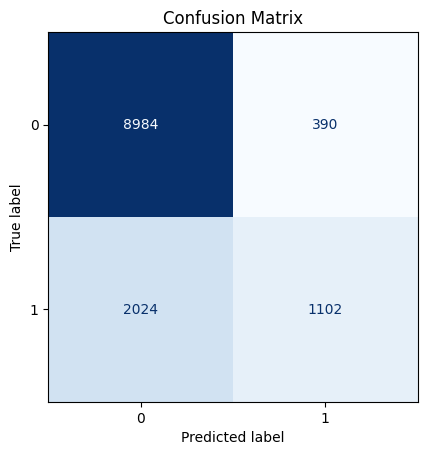


Current Fold 6:
Fold scores for current sign fold 6 of run 2:

Fold Accuracy Scores: [0.80392]

Fold F1 Scores: [0.6722423217809401]

Fold 6 Accuracy: 0.804, F1: 0.672
  Class 0 -> Precision: 0.813, Recall: 0.959
  Class 1 -> Precision: 0.733, Recall: 0.340
Fold 6 Accuracy: 0.804, F1: 0.672


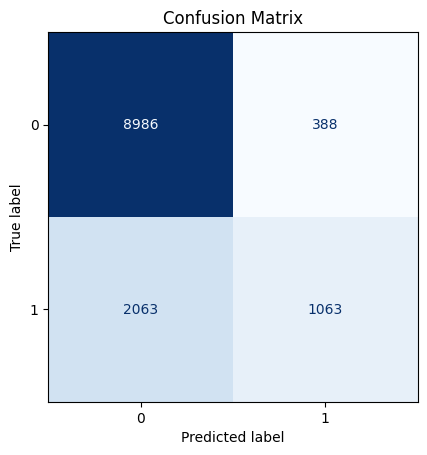


Current Fold 7:
Fold scores for current sign fold 7 of run 2:

Fold Accuracy Scores: [0.80448]

Fold F1 Scores: [0.6803253043187999]

Fold 7 Accuracy: 0.804, F1: 0.680
  Class 0 -> Precision: 0.817, Recall: 0.952
  Class 1 -> Precision: 0.715, Recall: 0.362
Fold 7 Accuracy: 0.804, F1: 0.680


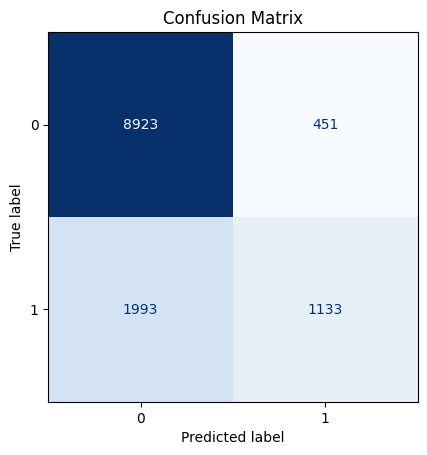


Current Fold 8:
Fold scores for current sign fold 8 of run 2:

Fold Accuracy Scores: [0.80736]

Fold F1 Scores: [0.6829613307619145]

Fold 8 Accuracy: 0.807, F1: 0.683
  Class 0 -> Precision: 0.818, Recall: 0.956
  Class 1 -> Precision: 0.733, Recall: 0.362
Fold 8 Accuracy: 0.807, F1: 0.683


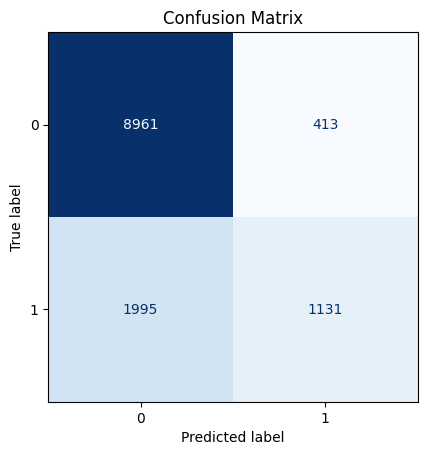


At fold 8 of run 2:


Overall Accuracy Scores for run 2: [np.float64(0.79776), np.float64(0.80736), np.float64(0.80736)]
Overall F1 Scores for run 2: [np.float64(0.6623460639979867), np.float64(0.6808502742461016), np.float64(0.6829613307619145)]

=== Final Results for current run ===
Average Accuracy: 0.80416
Average F1-score: 0.6753858896686675

Current Fold 1:
Fold scores for current sign fold 1 of run 3:

Fold Accuracy Scores: [0.80616]

Fold F1 Scores: [0.6746609607364145]

Fold 1 Accuracy: 0.806, F1: 0.675
  Class 0 -> Precision: 0.814, Recall: 0.961
  Class 1 -> Precision: 0.746, Recall: 0.341
Fold 1 Accuracy: 0.806, F1: 0.675


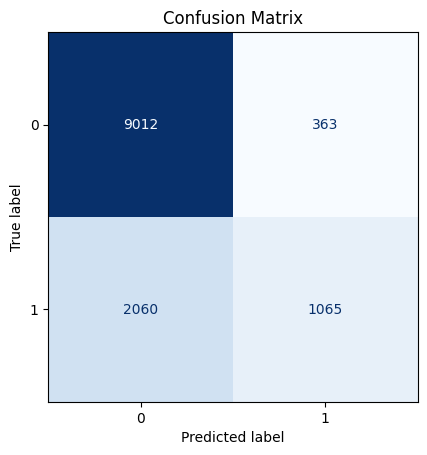


Current Fold 2:
Fold scores for current sign fold 2 of run 3:

Fold Accuracy Scores: [0.8048]

Fold F1 Scores: [0.6715363856484189]

Fold 2 Accuracy: 0.805, F1: 0.672
  Class 0 -> Precision: 0.813, Recall: 0.961
  Class 1 -> Precision: 0.743, Recall: 0.336
Fold 2 Accuracy: 0.805, F1: 0.672


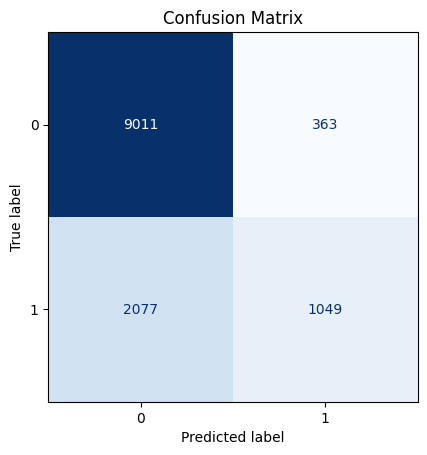


Current Fold 3:
Fold scores for current sign fold 3 of run 3:

Fold Accuracy Scores: [0.808]

Fold F1 Scores: [0.6790078311817442]

Fold 3 Accuracy: 0.808, F1: 0.679
  Class 0 -> Precision: 0.816, Recall: 0.961
  Class 1 -> Precision: 0.750, Recall: 0.348
Fold 3 Accuracy: 0.808, F1: 0.679


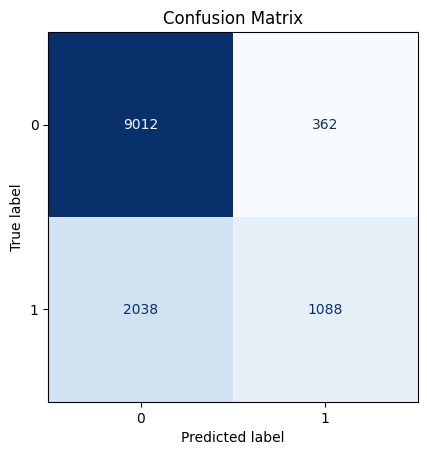


Current Fold 4:
Fold scores for current sign fold 4 of run 3:

Fold Accuracy Scores: [0.80648]

Fold F1 Scores: [0.6755302972397867]

Fold 4 Accuracy: 0.806, F1: 0.676
  Class 0 -> Precision: 0.814, Recall: 0.961
  Class 1 -> Precision: 0.747, Recall: 0.342
Fold 4 Accuracy: 0.806, F1: 0.676


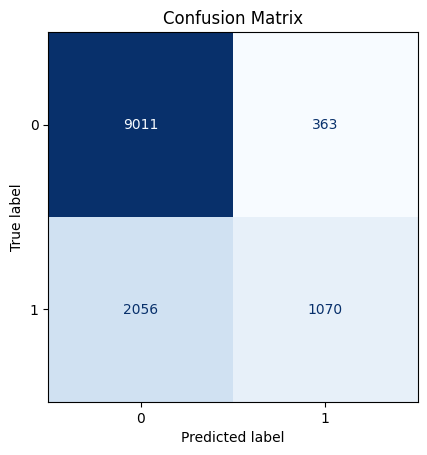


Current Fold 5:
Fold scores for current sign fold 5 of run 3:

Fold Accuracy Scores: [0.80136]

Fold F1 Scores: [0.6667184776483935]

Fold 5 Accuracy: 0.801, F1: 0.667
  Class 0 -> Precision: 0.811, Recall: 0.958
  Class 1 -> Precision: 0.725, Recall: 0.331
Fold 5 Accuracy: 0.801, F1: 0.667


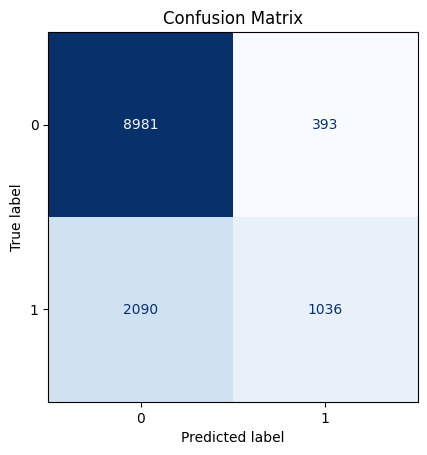


Current Fold 6:
Fold scores for current sign fold 6 of run 3:

Fold Accuracy Scores: [0.80336]

Fold F1 Scores: [0.6732406917253674]

Fold 6 Accuracy: 0.803, F1: 0.673
  Class 0 -> Precision: 0.814, Recall: 0.956
  Class 1 -> Precision: 0.725, Recall: 0.345
Fold 6 Accuracy: 0.803, F1: 0.673


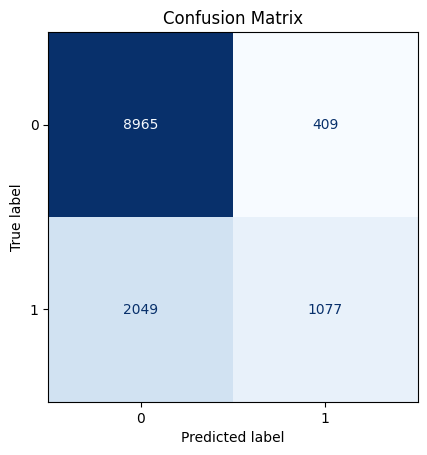


Current Fold 7:
Fold scores for current sign fold 7 of run 3:

Fold Accuracy Scores: [0.7996]

Fold F1 Scores: [0.6651347403160416]

Fold 7 Accuracy: 0.800, F1: 0.665
  Class 0 -> Precision: 0.811, Recall: 0.956
  Class 1 -> Precision: 0.714, Recall: 0.332
Fold 7 Accuracy: 0.800, F1: 0.665


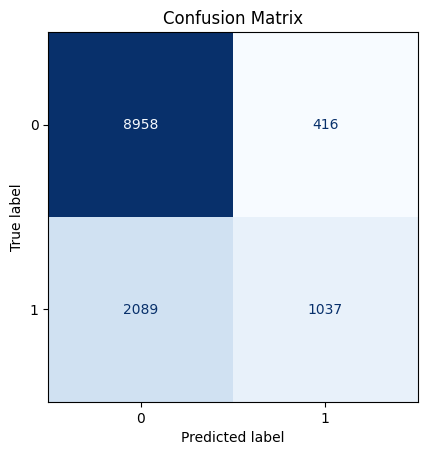


Current Fold 8:
Fold scores for current sign fold 8 of run 3:

Fold Accuracy Scores: [0.84568]

Fold F1 Scores: [0.7594876115098472]

Fold 8 Accuracy: 0.846, F1: 0.759
  Class 0 -> Precision: 0.851, Recall: 0.963
  Class 1 -> Precision: 0.816, Recall: 0.494
Fold 8 Accuracy: 0.846, F1: 0.759


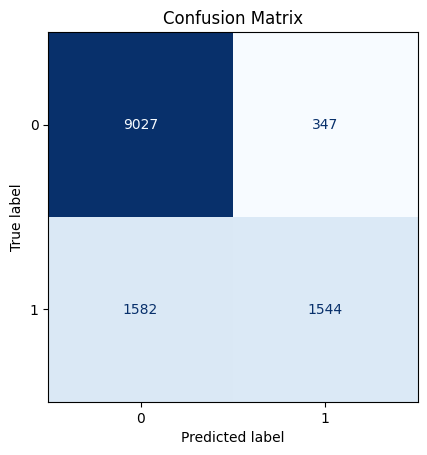


At fold 8 of run 3:


Overall Accuracy Scores for run 3: [np.float64(0.79776), np.float64(0.80736), np.float64(0.80736), np.float64(0.84568)]
Overall F1 Scores for run 3: [np.float64(0.6623460639979867), np.float64(0.6808502742461016), np.float64(0.6829613307619145), np.float64(0.7594876115098472)]

=== Final Results for current run ===
Average Accuracy: 0.81454
Average F1-score: 0.6964113201289625

Current Fold 1:
Fold scores for current sign fold 1 of run 4:

Fold Accuracy Scores: [0.79856]

Fold F1 Scores: [0.653982472109723]

Fold 1 Accuracy: 0.799, F1: 0.654
  Class 0 -> Precision: 0.806, Recall: 0.963
  Class 1 -> Precision: 0.734, Recall: 0.304
Fold 1 Accuracy: 0.799, F1: 0.654


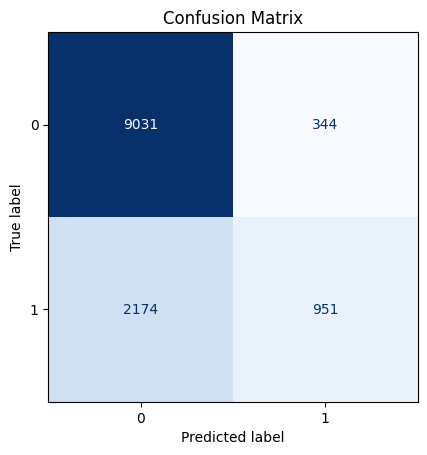


Current Fold 2:
Fold scores for current sign fold 2 of run 4:

Fold Accuracy Scores: [0.80696]

Fold F1 Scores: [0.6775424321285485]

Fold 2 Accuracy: 0.807, F1: 0.678
  Class 0 -> Precision: 0.815, Recall: 0.960
  Class 1 -> Precision: 0.745, Recall: 0.347
Fold 2 Accuracy: 0.807, F1: 0.678


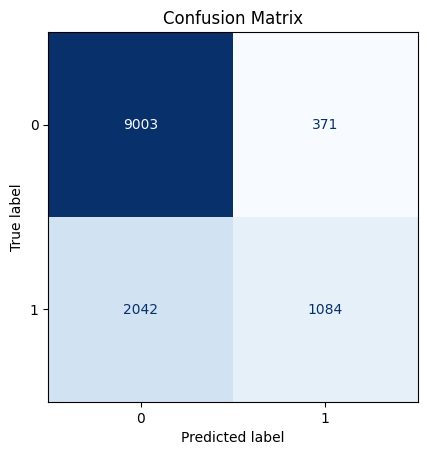


Current Fold 3:
Fold scores for current sign fold 3 of run 4:

Fold Accuracy Scores: [0.84456]

Fold F1 Scores: [0.7569426462203268]

Fold 3 Accuracy: 0.845, F1: 0.757
  Class 0 -> Precision: 0.849, Recall: 0.963
  Class 1 -> Precision: 0.816, Recall: 0.488
Fold 3 Accuracy: 0.845, F1: 0.757


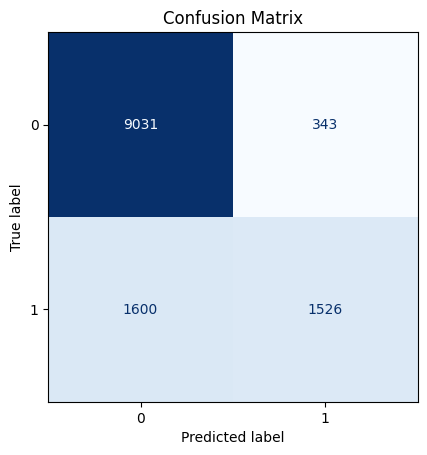


Current Fold 4:
Fold scores for current sign fold 4 of run 4:

Fold Accuracy Scores: [0.80768]

Fold F1 Scores: [0.682016759970674]

Fold 4 Accuracy: 0.808, F1: 0.682
  Class 0 -> Precision: 0.817, Recall: 0.958
  Class 1 -> Precision: 0.738, Recall: 0.358
Fold 4 Accuracy: 0.808, F1: 0.682


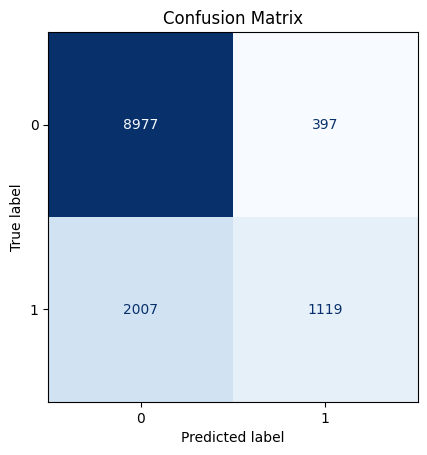


Current Fold 5:
Fold scores for current sign fold 5 of run 4:

Fold Accuracy Scores: [0.79592]

Fold F1 Scores: [0.648635563881272]

Fold 5 Accuracy: 0.796, F1: 0.649
  Class 0 -> Precision: 0.804, Recall: 0.962
  Class 1 -> Precision: 0.724, Recall: 0.297
Fold 5 Accuracy: 0.796, F1: 0.649


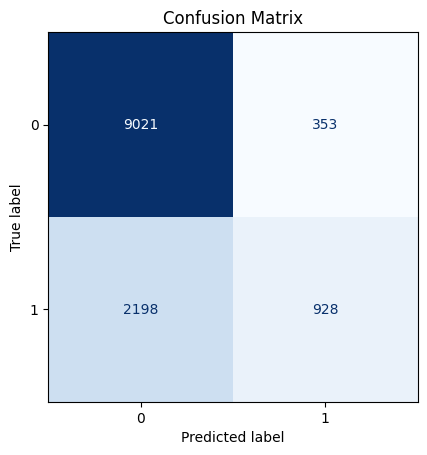


Current Fold 6:
Fold scores for current sign fold 6 of run 4:

Fold Accuracy Scores: [0.80736]

Fold F1 Scores: [0.6812755956344965]

Fold 6 Accuracy: 0.807, F1: 0.681
  Class 0 -> Precision: 0.817, Recall: 0.958
  Class 1 -> Precision: 0.737, Recall: 0.357
Fold 6 Accuracy: 0.807, F1: 0.681


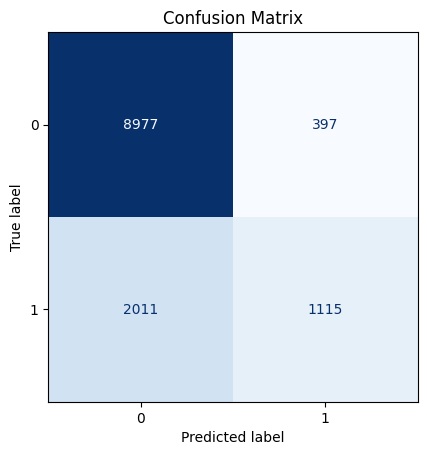


Current Fold 7:
Fold scores for current sign fold 7 of run 4:

Fold Accuracy Scores: [0.81088]

Fold F1 Scores: [0.6899797814360606]

Fold 7 Accuracy: 0.811, F1: 0.690
  Class 0 -> Precision: 0.821, Recall: 0.957
  Class 1 -> Precision: 0.743, Recall: 0.373
Fold 7 Accuracy: 0.811, F1: 0.690


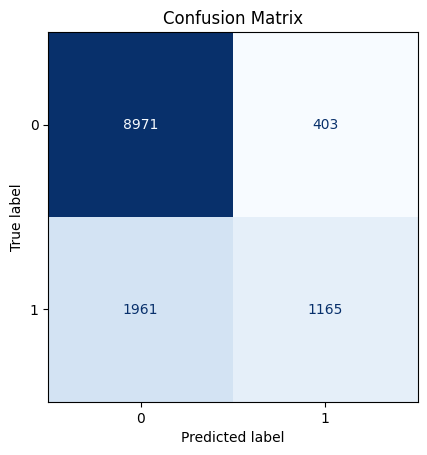


Current Fold 8:
Fold scores for current sign fold 8 of run 4:

Fold Accuracy Scores: [0.79432]

Fold F1 Scores: [0.6560788169432349]

Fold 8 Accuracy: 0.794, F1: 0.656
  Class 0 -> Precision: 0.808, Recall: 0.952
  Class 1 -> Precision: 0.692, Recall: 0.321
Fold 8 Accuracy: 0.794, F1: 0.656


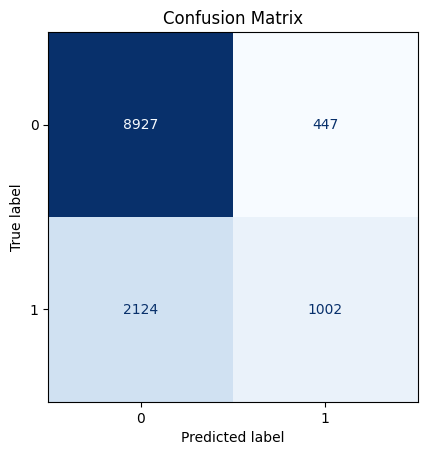


At fold 8 of run 4:


Overall Accuracy Scores for run 4: [np.float64(0.79776), np.float64(0.80736), np.float64(0.80736), np.float64(0.84568), np.float64(0.79432)]
Overall F1 Scores for run 4: [np.float64(0.6623460639979867), np.float64(0.6808502742461016), np.float64(0.6829613307619145), np.float64(0.7594876115098472), np.float64(0.6560788169432349)]

=== Final Results for current run ===
Average Accuracy: 0.810496
Average F1-score: 0.6883448194918169

Current Fold 1:
Fold scores for current sign fold 1 of run 5:

Fold Accuracy Scores: [0.79632]

Fold F1 Scores: [0.6524753430573408]

Fold 1 Accuracy: 0.796, F1: 0.652
  Class 0 -> Precision: 0.806, Recall: 0.960
  Class 1 -> Precision: 0.717, Recall: 0.306
Fold 1 Accuracy: 0.796, F1: 0.652


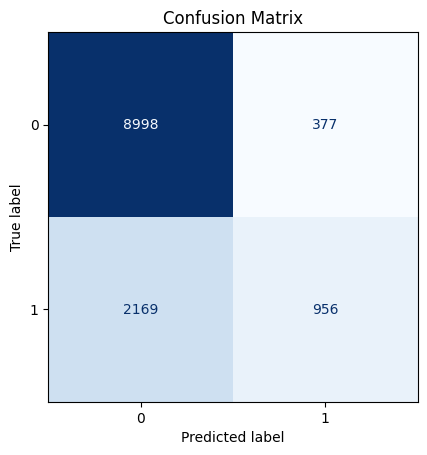


Current Fold 2:
Fold scores for current sign fold 2 of run 5:

Fold Accuracy Scores: [0.80416]

Fold F1 Scores: [0.6744608124224052]

Fold 2 Accuracy: 0.804, F1: 0.674
  Class 0 -> Precision: 0.814, Recall: 0.957
  Class 1 -> Precision: 0.728, Recall: 0.346
Fold 2 Accuracy: 0.804, F1: 0.674


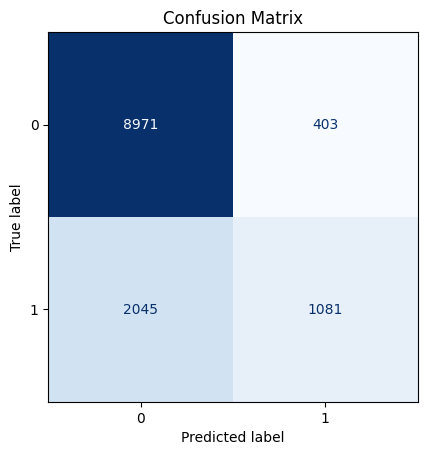


Current Fold 3:
Fold scores for current sign fold 3 of run 5:

Fold Accuracy Scores: [0.80944]

Fold F1 Scores: [0.6851361550576323]

Fold 3 Accuracy: 0.809, F1: 0.685
  Class 0 -> Precision: 0.818, Recall: 0.959
  Class 1 -> Precision: 0.745, Recall: 0.362
Fold 3 Accuracy: 0.809, F1: 0.685


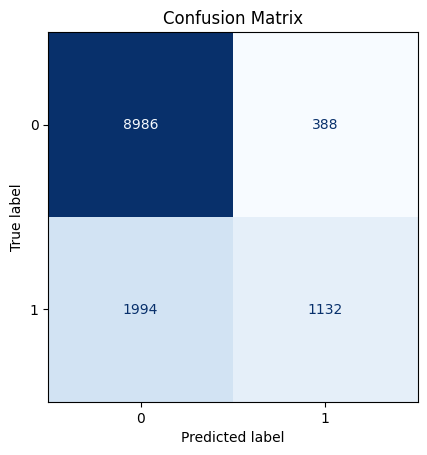


Current Fold 4:
Fold scores for current sign fold 4 of run 5:

Fold Accuracy Scores: [0.79448]

Fold F1 Scores: [0.6394251998089675]

Fold 4 Accuracy: 0.794, F1: 0.639
  Class 0 -> Precision: 0.800, Recall: 0.967
  Class 1 -> Precision: 0.737, Recall: 0.277
Fold 4 Accuracy: 0.794, F1: 0.639


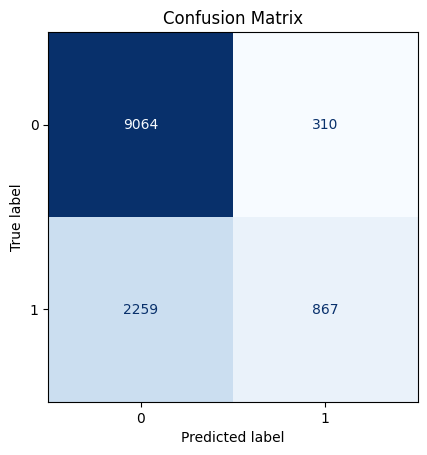


Current Fold 5:
Fold scores for current sign fold 5 of run 5:

Fold Accuracy Scores: [0.84384]

Fold F1 Scores: [0.7579535184253519]

Fold 5 Accuracy: 0.844, F1: 0.758
  Class 0 -> Precision: 0.851, Recall: 0.960
  Class 1 -> Precision: 0.804, Recall: 0.496
Fold 5 Accuracy: 0.844, F1: 0.758


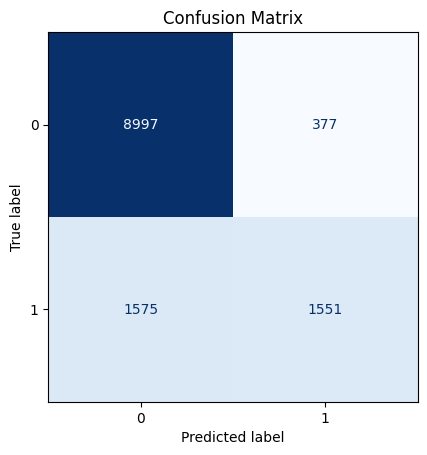


Current Fold 6:
Fold scores for current sign fold 6 of run 5:

Fold Accuracy Scores: [0.80272]

Fold F1 Scores: [0.6682638645041754]

Fold 6 Accuracy: 0.803, F1: 0.668
  Class 0 -> Precision: 0.812, Recall: 0.960
  Class 1 -> Precision: 0.733, Recall: 0.332
Fold 6 Accuracy: 0.803, F1: 0.668


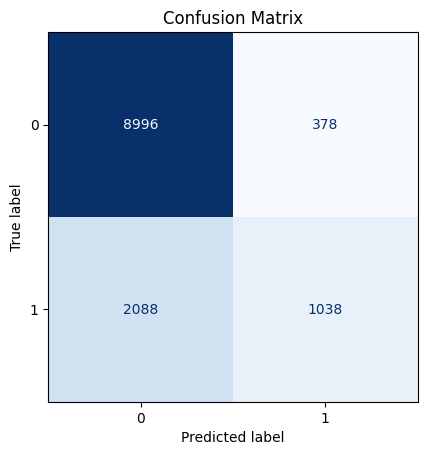


Current Fold 7:
Fold scores for current sign fold 7 of run 5:

Fold Accuracy Scores: [0.80992]

Fold F1 Scores: [0.6874836376113295]

Fold 7 Accuracy: 0.810, F1: 0.687
  Class 0 -> Precision: 0.820, Recall: 0.957
  Class 1 -> Precision: 0.742, Recall: 0.368
Fold 7 Accuracy: 0.810, F1: 0.687


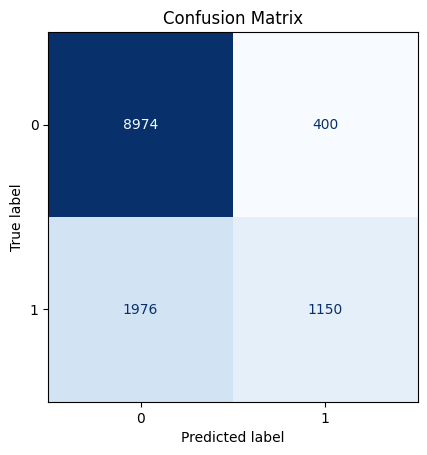


Current Fold 8:
Fold scores for current sign fold 8 of run 5:

Fold Accuracy Scores: [0.80432]

Fold F1 Scores: [0.6758138583081248]

Fold 8 Accuracy: 0.804, F1: 0.676
  Class 0 -> Precision: 0.815, Recall: 0.956
  Class 1 -> Precision: 0.726, Recall: 0.349
Fold 8 Accuracy: 0.804, F1: 0.676


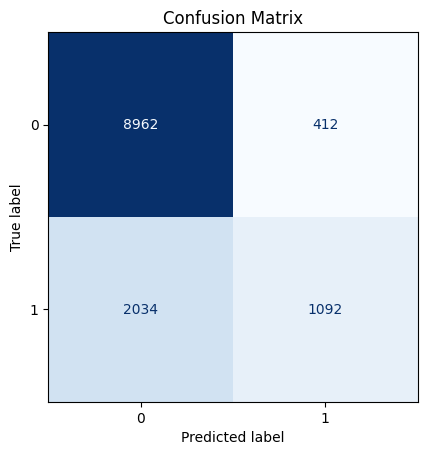


At fold 8 of run 5:


Overall Accuracy Scores for run 5: [np.float64(0.79776), np.float64(0.80736), np.float64(0.80736), np.float64(0.84568), np.float64(0.79432), np.float64(0.80432)]
Overall F1 Scores for run 5: [np.float64(0.6623460639979867), np.float64(0.6808502742461016), np.float64(0.6829613307619145), np.float64(0.7594876115098472), np.float64(0.6560788169432349), np.float64(0.6758138583081248)]

=== Final Results for current run ===
Average Accuracy: 0.8094666666666667
Average F1-score: 0.6862563259612017

Current Fold 1:
Fold scores for current sign fold 1 of run 6:

Fold Accuracy Scores: [0.83568]

Fold F1 Scores: [0.7354520905848312]

Fold 1 Accuracy: 0.836, F1: 0.735
  Class 0 -> Precision: 0.838, Recall: 0.967
  Class 1 -> Precision: 0.819, Recall: 0.440
Fold 1 Accuracy: 0.836, F1: 0.735


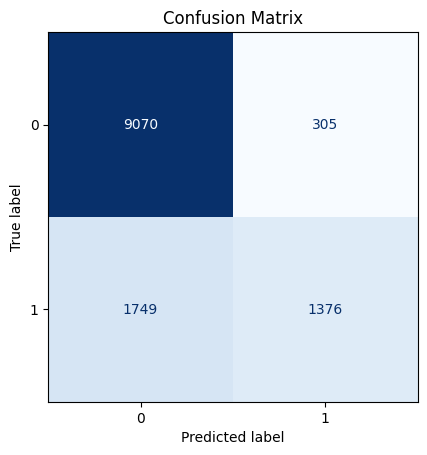


Current Fold 2:
Fold scores for current sign fold 2 of run 6:

Fold Accuracy Scores: [0.80368]

Fold F1 Scores: [0.67442742530394]

Fold 2 Accuracy: 0.804, F1: 0.674
  Class 0 -> Precision: 0.814, Recall: 0.956
  Class 1 -> Precision: 0.724, Recall: 0.347
Fold 2 Accuracy: 0.804, F1: 0.674


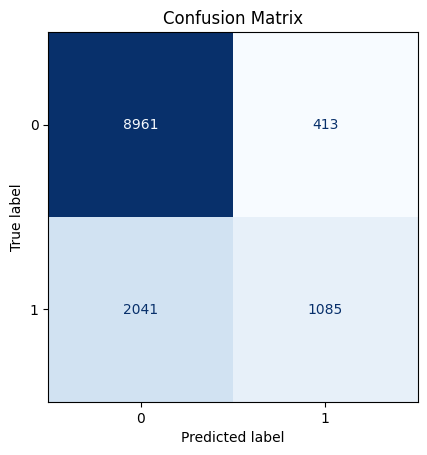


Current Fold 3:
Fold scores for current sign fold 3 of run 6:

Fold Accuracy Scores: [0.80128]

Fold F1 Scores: [0.6693402856286534]

Fold 3 Accuracy: 0.801, F1: 0.669
  Class 0 -> Precision: 0.813, Recall: 0.955
  Class 1 -> Precision: 0.717, Recall: 0.339
Fold 3 Accuracy: 0.801, F1: 0.669


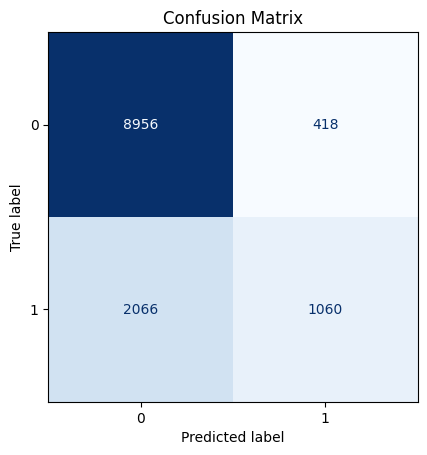


Current Fold 4:
Fold scores for current sign fold 4 of run 6:

Fold Accuracy Scores: [0.79752]

Fold F1 Scores: [0.6591108976494948]

Fold 4 Accuracy: 0.798, F1: 0.659
  Class 0 -> Precision: 0.808, Recall: 0.957
  Class 1 -> Precision: 0.711, Recall: 0.321
Fold 4 Accuracy: 0.798, F1: 0.659


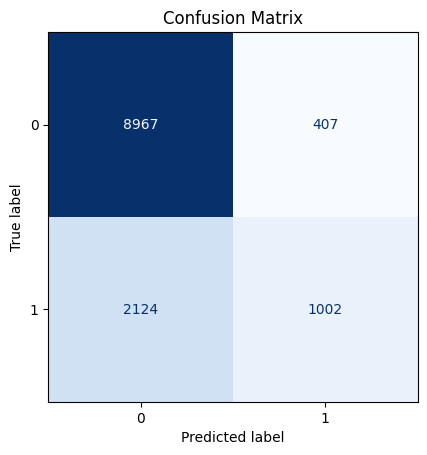


Current Fold 5:
Fold scores for current sign fold 5 of run 6:

Fold Accuracy Scores: [0.80208]

Fold F1 Scores: [0.6713342132613611]

Fold 5 Accuracy: 0.802, F1: 0.671
  Class 0 -> Precision: 0.813, Recall: 0.955
  Class 1 -> Precision: 0.719, Recall: 0.343
Fold 5 Accuracy: 0.802, F1: 0.671


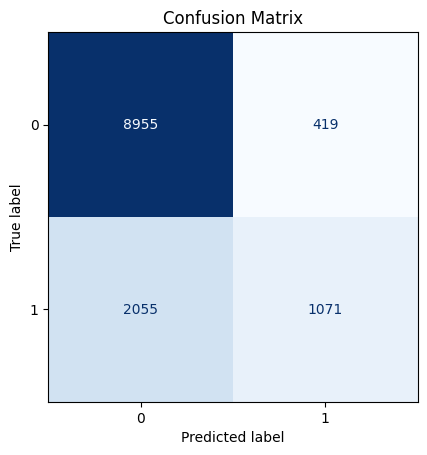


Current Fold 6:
Fold scores for current sign fold 6 of run 6:

Fold Accuracy Scores: [0.80816]

Fold F1 Scores: [0.6836512974634396]

Fold 6 Accuracy: 0.808, F1: 0.684
  Class 0 -> Precision: 0.818, Recall: 0.957
  Class 1 -> Precision: 0.738, Recall: 0.361
Fold 6 Accuracy: 0.808, F1: 0.684


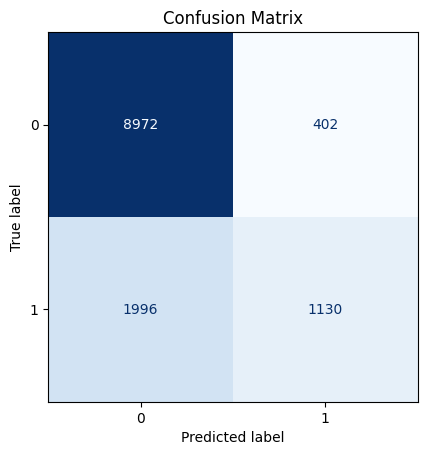


Current Fold 7:
Fold scores for current sign fold 7 of run 6:

Fold Accuracy Scores: [0.80256]

Fold F1 Scores: [0.6705828545732966]

Fold 7 Accuracy: 0.803, F1: 0.671
  Class 0 -> Precision: 0.813, Recall: 0.957
  Class 1 -> Precision: 0.725, Recall: 0.339
Fold 7 Accuracy: 0.803, F1: 0.671


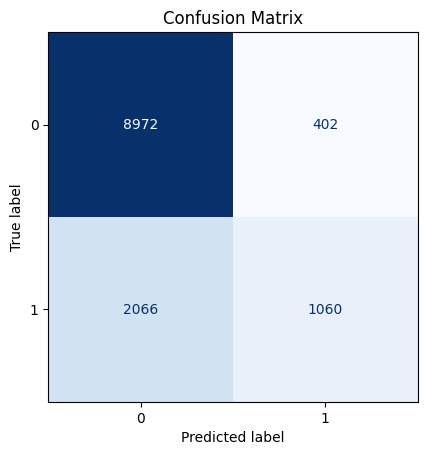


Current Fold 8:
Fold scores for current sign fold 8 of run 6:

Fold Accuracy Scores: [0.80832]

Fold F1 Scores: [0.6812688322762739]

Fold 8 Accuracy: 0.808, F1: 0.681
  Class 0 -> Precision: 0.817, Recall: 0.960
  Class 1 -> Precision: 0.746, Recall: 0.354
Fold 8 Accuracy: 0.808, F1: 0.681


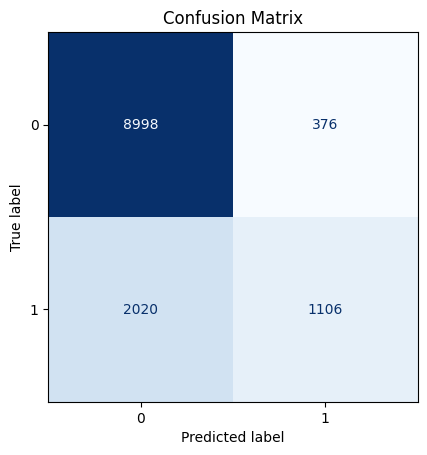


At fold 8 of run 6:


Overall Accuracy Scores for run 6: [np.float64(0.79776), np.float64(0.80736), np.float64(0.80736), np.float64(0.84568), np.float64(0.79432), np.float64(0.80432), np.float64(0.80832)]
Overall F1 Scores for run 6: [np.float64(0.6623460639979867), np.float64(0.6808502742461016), np.float64(0.6829613307619145), np.float64(0.7594876115098472), np.float64(0.6560788169432349), np.float64(0.6758138583081248), np.float64(0.6812688322762739)]

=== Final Results for current run ===
Average Accuracy: 0.8093028571428571
Average F1-score: 0.6855438268633548

Current Fold 1:
Fold scores for current sign fold 1 of run 7:

Fold Accuracy Scores: [0.80376]

Fold F1 Scores: [0.6733020194095838]

Fold 1 Accuracy: 0.804, F1: 0.673
  Class 0 -> Precision: 0.814, Recall: 0.957
  Class 1 -> Precision: 0.728, Recall: 0.344
Fold 1 Accuracy: 0.804, F1: 0.673


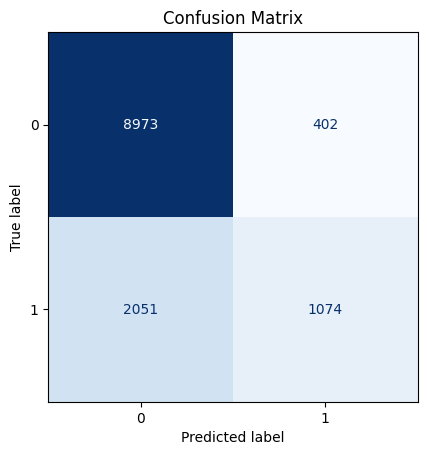


Current Fold 2:
Fold scores for current sign fold 2 of run 7:

Fold Accuracy Scores: [0.8056]

Fold F1 Scores: [0.6778269053003928]

Fold 2 Accuracy: 0.806, F1: 0.678
  Class 0 -> Precision: 0.816, Recall: 0.957
  Class 1 -> Precision: 0.732, Recall: 0.352
Fold 2 Accuracy: 0.806, F1: 0.678


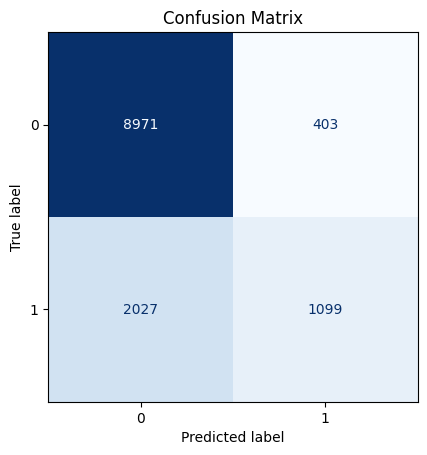


Current Fold 3:
Fold scores for current sign fold 3 of run 7:

Fold Accuracy Scores: [0.80832]

Fold F1 Scores: [0.6808397271952259]

Fold 3 Accuracy: 0.808, F1: 0.681
  Class 0 -> Precision: 0.816, Recall: 0.960
  Class 1 -> Precision: 0.748, Recall: 0.353
Fold 3 Accuracy: 0.808, F1: 0.681


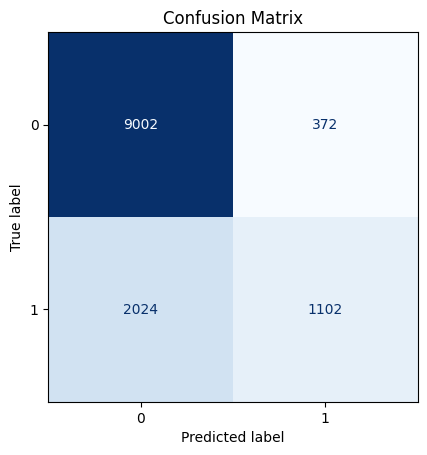


Current Fold 4:
Fold scores for current sign fold 4 of run 7:

Fold Accuracy Scores: [0.8024]

Fold F1 Scores: [0.6715352151484235]

Fold 4 Accuracy: 0.802, F1: 0.672
  Class 0 -> Precision: 0.813, Recall: 0.956
  Class 1 -> Precision: 0.721, Recall: 0.342
Fold 4 Accuracy: 0.802, F1: 0.672


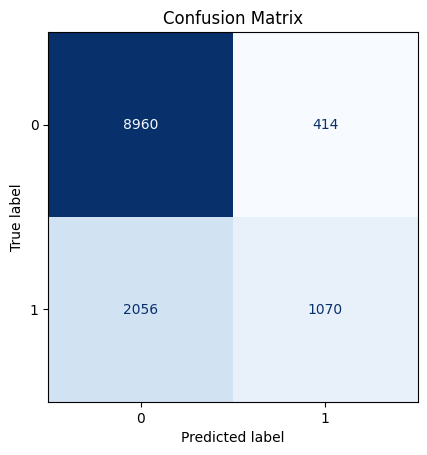


Current Fold 5:
Fold scores for current sign fold 5 of run 7:

Fold Accuracy Scores: [0.806]

Fold F1 Scores: [0.6706660474844313]

Fold 5 Accuracy: 0.806, F1: 0.671
  Class 0 -> Precision: 0.812, Recall: 0.965
  Class 1 -> Precision: 0.758, Recall: 0.330
Fold 5 Accuracy: 0.806, F1: 0.671


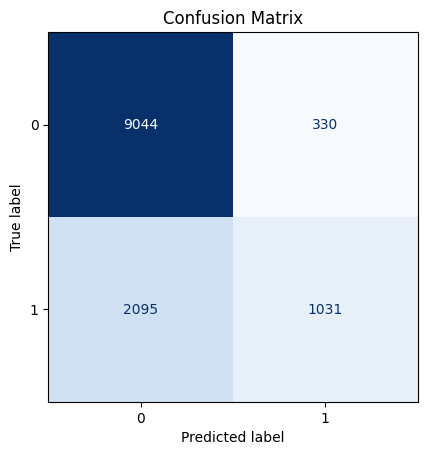


Current Fold 6:
Fold scores for current sign fold 6 of run 7:

Fold Accuracy Scores: [0.80144]

Fold F1 Scores: [0.6610921708697572]

Fold 6 Accuracy: 0.801, F1: 0.661
  Class 0 -> Precision: 0.809, Recall: 0.963
  Class 1 -> Precision: 0.742, Recall: 0.316
Fold 6 Accuracy: 0.801, F1: 0.661


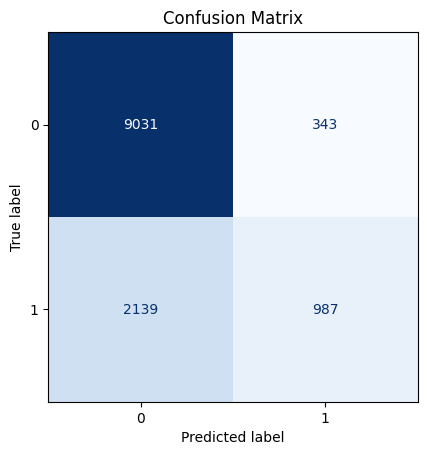


Current Fold 7:
Fold scores for current sign fold 7 of run 7:

Fold Accuracy Scores: [0.84032]

Fold F1 Scores: [0.7526436789266968]

Fold 7 Accuracy: 0.840, F1: 0.753
  Class 0 -> Precision: 0.849, Recall: 0.957
  Class 1 -> Precision: 0.792, Recall: 0.490
Fold 7 Accuracy: 0.840, F1: 0.753


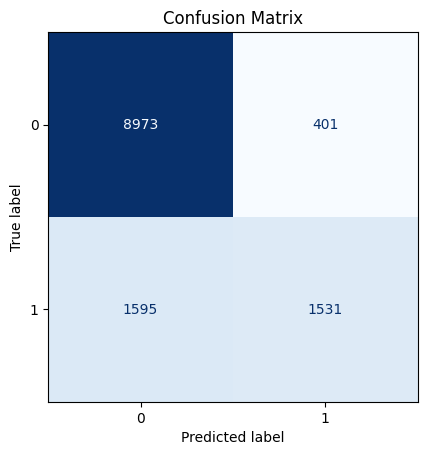


Current Fold 8:
Fold scores for current sign fold 8 of run 7:

Fold Accuracy Scores: [0.80272]

Fold F1 Scores: [0.6682638645041754]

Fold 8 Accuracy: 0.803, F1: 0.668
  Class 0 -> Precision: 0.812, Recall: 0.960
  Class 1 -> Precision: 0.733, Recall: 0.332
Fold 8 Accuracy: 0.803, F1: 0.668


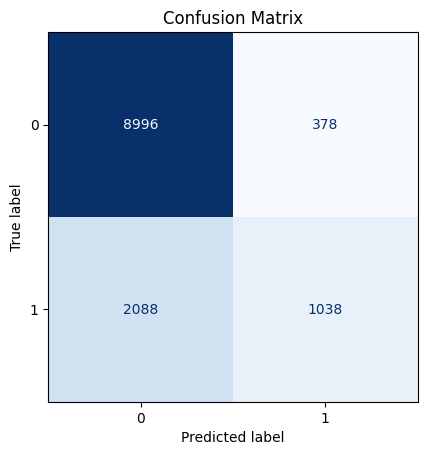


At fold 8 of run 7:


Overall Accuracy Scores for run 7: [np.float64(0.79776), np.float64(0.80736), np.float64(0.80736), np.float64(0.84568), np.float64(0.79432), np.float64(0.80432), np.float64(0.80832), np.float64(0.80272)]
Overall F1 Scores for run 7: [np.float64(0.6623460639979867), np.float64(0.6808502742461016), np.float64(0.6829613307619145), np.float64(0.7594876115098472), np.float64(0.6560788169432349), np.float64(0.6758138583081248), np.float64(0.6812688322762739), np.float64(0.6682638645041754)]

=== Final Results for current run ===
Average Accuracy: 0.80848
Average F1-score: 0.6833838315684573

Current Fold 1:
Fold scores for current sign fold 1 of run 8:

Fold Accuracy Scores: [0.80288]

Fold F1 Scores: [0.6689862704532632]

Fold 1 Accuracy: 0.803, F1: 0.669
  Class 0 -> Precision: 0.812, Recall: 0.959
  Class 1 -> Precision: 0.732, Recall: 0.334
Fold 1 Accuracy: 0.803, F1: 0.669


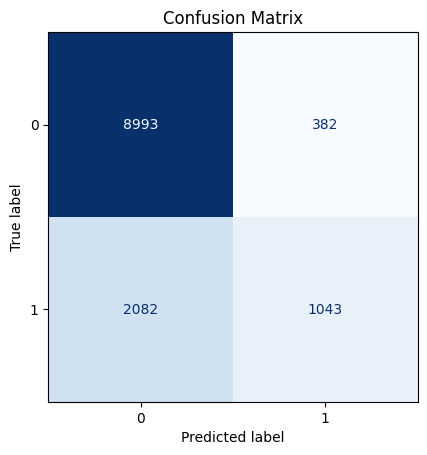


Current Fold 2:
Fold scores for current sign fold 2 of run 8:

Fold Accuracy Scores: [0.80536]

Fold F1 Scores: [0.6756379719814134]

Fold 2 Accuracy: 0.805, F1: 0.676
  Class 0 -> Precision: 0.815, Recall: 0.959
  Class 1 -> Precision: 0.736, Recall: 0.346
Fold 2 Accuracy: 0.805, F1: 0.676


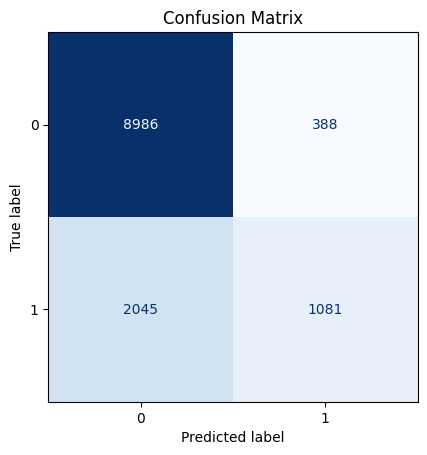


Current Fold 3:
Fold scores for current sign fold 3 of run 8:

Fold Accuracy Scores: [0.79552]

Fold F1 Scores: [0.6548542934181416]

Fold 3 Accuracy: 0.796, F1: 0.655
  Class 0 -> Precision: 0.807, Recall: 0.956
  Class 1 -> Precision: 0.704, Recall: 0.314
Fold 3 Accuracy: 0.796, F1: 0.655


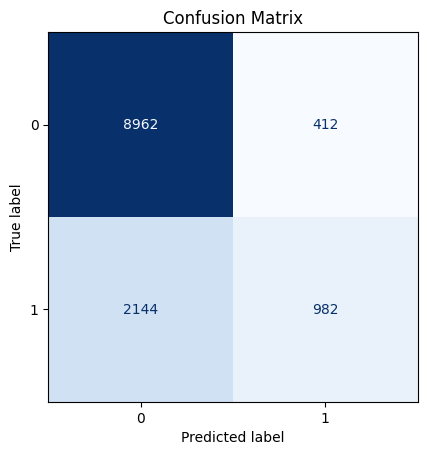


Current Fold 4:
Fold scores for current sign fold 4 of run 8:

Fold Accuracy Scores: [0.83472]

Fold F1 Scores: [0.7400291594166764]

Fold 4 Accuracy: 0.835, F1: 0.740
  Class 0 -> Precision: 0.842, Recall: 0.959
  Class 1 -> Precision: 0.790, Recall: 0.462
Fold 4 Accuracy: 0.835, F1: 0.740


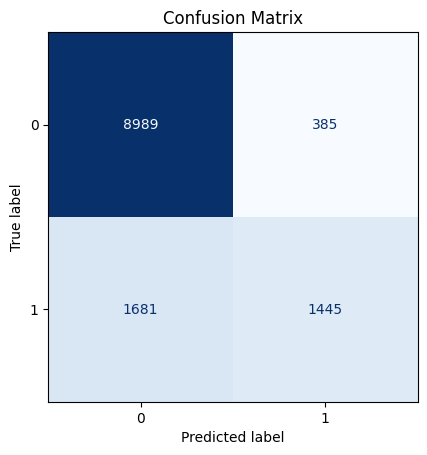


Current Fold 5:
Fold scores for current sign fold 5 of run 8:

Fold Accuracy Scores: [0.80512]

Fold F1 Scores: [0.6747441352575606]

Fold 5 Accuracy: 0.805, F1: 0.675
  Class 0 -> Precision: 0.814, Recall: 0.959
  Class 1 -> Precision: 0.736, Recall: 0.344
Fold 5 Accuracy: 0.805, F1: 0.675


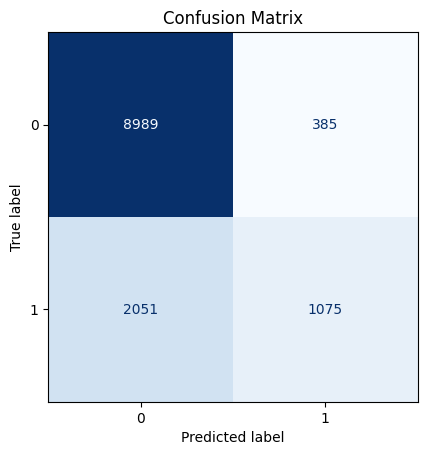


Current Fold 6:
Fold scores for current sign fold 6 of run 8:

Fold Accuracy Scores: [0.80656]

Fold F1 Scores: [0.6740505407687555]

Fold 6 Accuracy: 0.807, F1: 0.674
  Class 0 -> Precision: 0.813, Recall: 0.963
  Class 1 -> Precision: 0.752, Recall: 0.338
Fold 6 Accuracy: 0.807, F1: 0.674


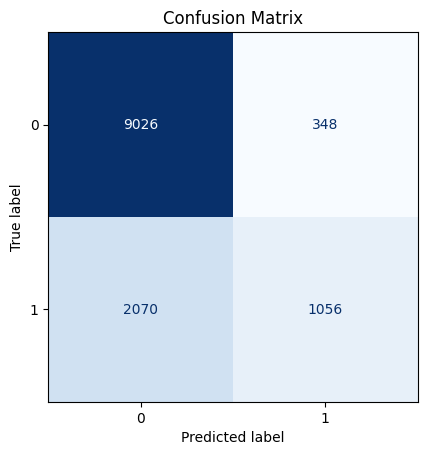


Current Fold 7:
Fold scores for current sign fold 7 of run 8:

Fold Accuracy Scores: [0.80504]

Fold F1 Scores: [0.6741144586618323]

Fold 7 Accuracy: 0.805, F1: 0.674
  Class 0 -> Precision: 0.814, Recall: 0.959
  Class 1 -> Precision: 0.737, Recall: 0.342
Fold 7 Accuracy: 0.805, F1: 0.674


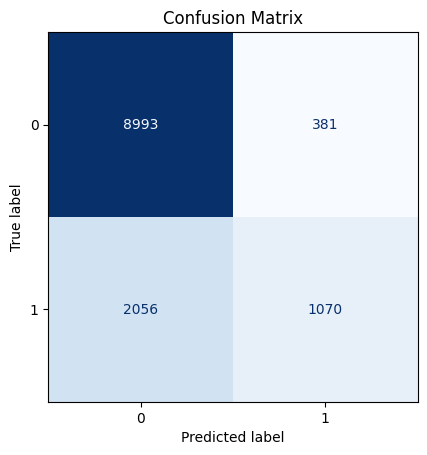


Current Fold 8:
Fold scores for current sign fold 8 of run 8:

Fold Accuracy Scores: [0.80192]

Fold F1 Scores: [0.6605974248567085]

Fold 8 Accuracy: 0.802, F1: 0.661
  Class 0 -> Precision: 0.808, Recall: 0.965
  Class 1 -> Precision: 0.748, Recall: 0.313
Fold 8 Accuracy: 0.802, F1: 0.661


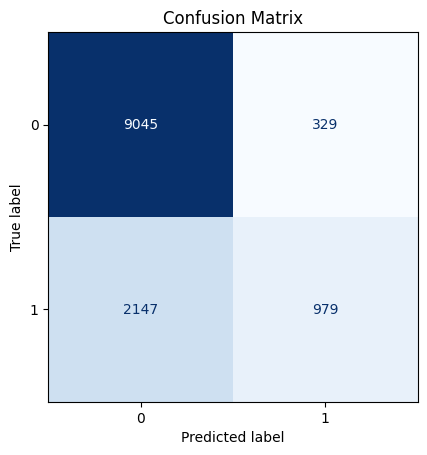


At fold 8 of run 8:


Overall Accuracy Scores for run 8: [np.float64(0.79776), np.float64(0.80736), np.float64(0.80736), np.float64(0.84568), np.float64(0.79432), np.float64(0.80432), np.float64(0.80832), np.float64(0.80272), np.float64(0.80192)]
Overall F1 Scores for run 8: [np.float64(0.6623460639979867), np.float64(0.6808502742461016), np.float64(0.6829613307619145), np.float64(0.7594876115098472), np.float64(0.6560788169432349), np.float64(0.6758138583081248), np.float64(0.6812688322762739), np.float64(0.6682638645041754), np.float64(0.6605974248567085)]

=== Final Results for current run ===
Average Accuracy: 0.8077511111111111
Average F1-score: 0.6808520086004851

Current Fold 1:
Fold scores for current sign fold 1 of run 9:

Fold Accuracy Scores: [0.80616]

Fold F1 Scores: [0.6735448542795308]

Fold 1 Accuracy: 0.806, F1: 0.674
  Class 0 -> Precision: 0.813, Recall: 0.962
  Class 1 -> Precision: 0.749, Recall: 0.338
Fold 1 Accuracy: 0.806, F1: 0.674


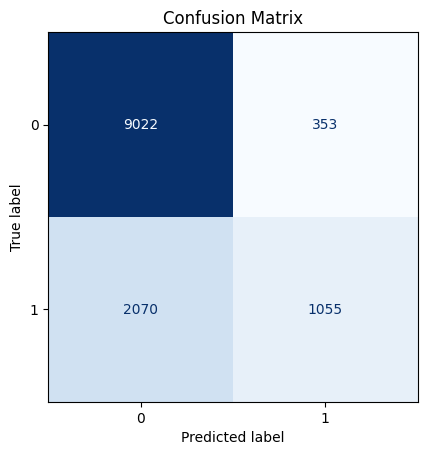


Current Fold 2:
Fold scores for current sign fold 2 of run 9:

Fold Accuracy Scores: [0.802]

Fold F1 Scores: [0.6632890215699746]

Fold 2 Accuracy: 0.802, F1: 0.663
  Class 0 -> Precision: 0.809, Recall: 0.963
  Class 1 -> Precision: 0.741, Recall: 0.320
Fold 2 Accuracy: 0.802, F1: 0.663


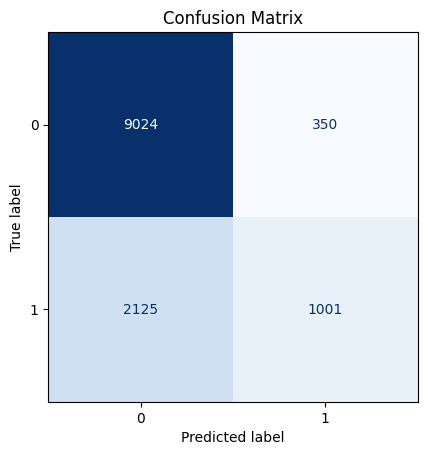


Current Fold 3:
Fold scores for current sign fold 3 of run 9:

Fold Accuracy Scores: [0.80832]

Fold F1 Scores: [0.6837056693166113]

Fold 3 Accuracy: 0.808, F1: 0.684
  Class 0 -> Precision: 0.818, Recall: 0.957
  Class 1 -> Precision: 0.739, Recall: 0.361
Fold 3 Accuracy: 0.808, F1: 0.684


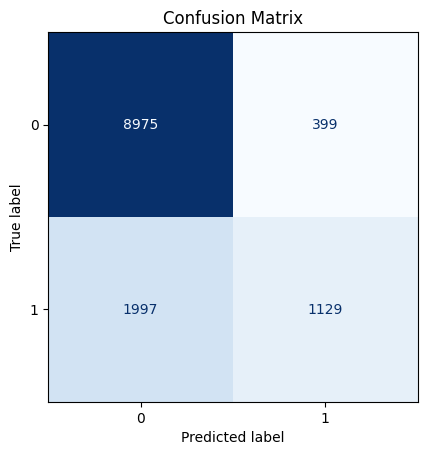


Current Fold 4:
Fold scores for current sign fold 4 of run 9:

Fold Accuracy Scores: [0.83832]

Fold F1 Scores: [0.7466520437385327]

Fold 4 Accuracy: 0.838, F1: 0.747
  Class 0 -> Precision: 0.845, Recall: 0.960
  Class 1 -> Precision: 0.798, Recall: 0.473
Fold 4 Accuracy: 0.838, F1: 0.747


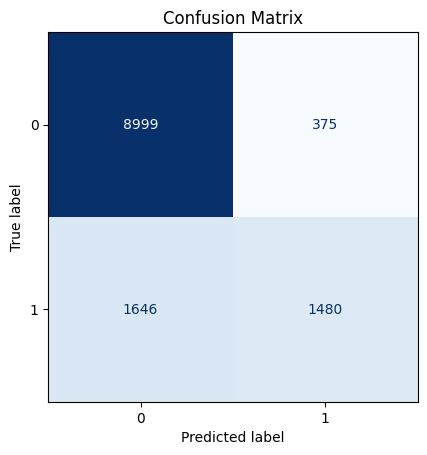


Current Fold 5:
Fold scores for current sign fold 5 of run 9:

Fold Accuracy Scores: [0.81]

Fold F1 Scores: [0.6894011234122042]

Fold 5 Accuracy: 0.810, F1: 0.689
  Class 0 -> Precision: 0.821, Recall: 0.956
  Class 1 -> Precision: 0.737, Recall: 0.374
Fold 5 Accuracy: 0.810, F1: 0.689


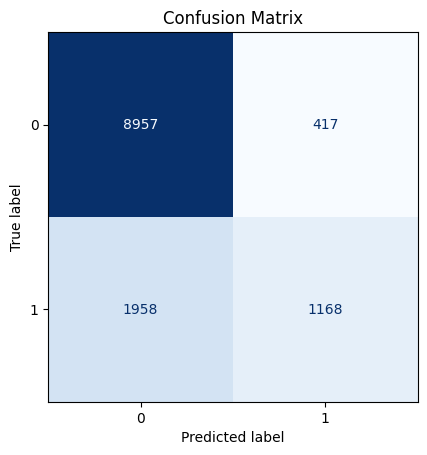


Current Fold 6:
Fold scores for current sign fold 6 of run 9:

Fold Accuracy Scores: [0.80464]

Fold F1 Scores: [0.6780598363841555]

Fold 6 Accuracy: 0.805, F1: 0.678
  Class 0 -> Precision: 0.816, Recall: 0.955
  Class 1 -> Precision: 0.723, Recall: 0.355
Fold 6 Accuracy: 0.805, F1: 0.678


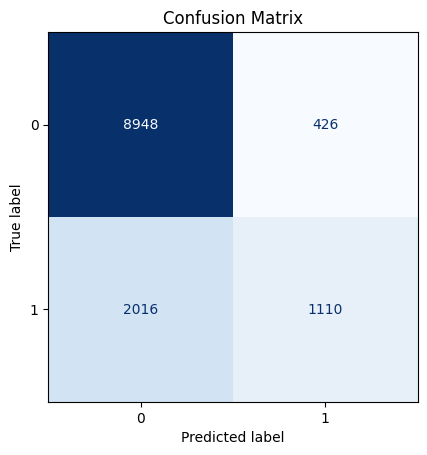


Current Fold 7:
Fold scores for current sign fold 7 of run 9:

Fold Accuracy Scores: [0.8048]

Fold F1 Scores: [0.6722104301566405]

Fold 7 Accuracy: 0.805, F1: 0.672
  Class 0 -> Precision: 0.813, Recall: 0.961
  Class 1 -> Precision: 0.741, Recall: 0.337
Fold 7 Accuracy: 0.805, F1: 0.672


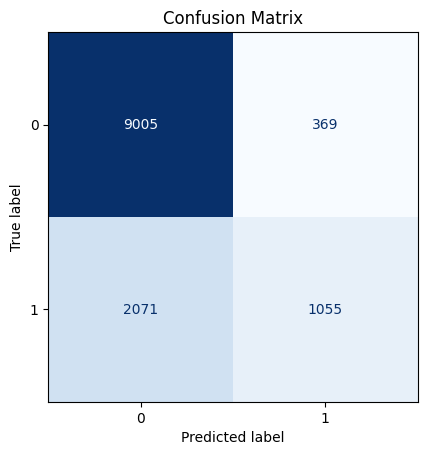


Current Fold 8:
Fold scores for current sign fold 8 of run 9:

Fold Accuracy Scores: [0.80248]

Fold F1 Scores: [0.6696112029598211]

Fold 8 Accuracy: 0.802, F1: 0.670
  Class 0 -> Precision: 0.812, Recall: 0.958
  Class 1 -> Precision: 0.727, Recall: 0.337
Fold 8 Accuracy: 0.802, F1: 0.670


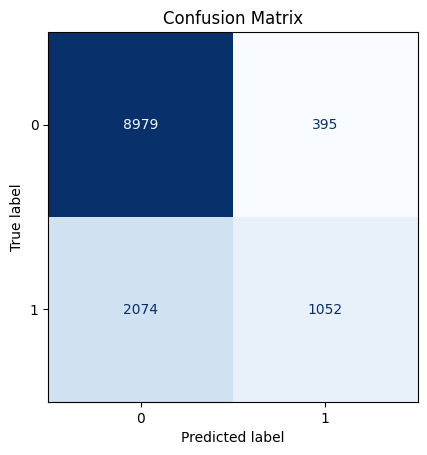


At fold 8 of run 9:


Overall Accuracy Scores for run 9: [np.float64(0.79776), np.float64(0.80736), np.float64(0.80736), np.float64(0.84568), np.float64(0.79432), np.float64(0.80432), np.float64(0.80832), np.float64(0.80272), np.float64(0.80192), np.float64(0.80248)]
Overall F1 Scores for run 9: [np.float64(0.6623460639979867), np.float64(0.6808502742461016), np.float64(0.6829613307619145), np.float64(0.7594876115098472), np.float64(0.6560788169432349), np.float64(0.6758138583081248), np.float64(0.6812688322762739), np.float64(0.6682638645041754), np.float64(0.6605974248567085), np.float64(0.6696112029598211)]

=== Final Results for current run ===
Average Accuracy: 0.8072239999999999
Average F1-score: 0.6797279280364188


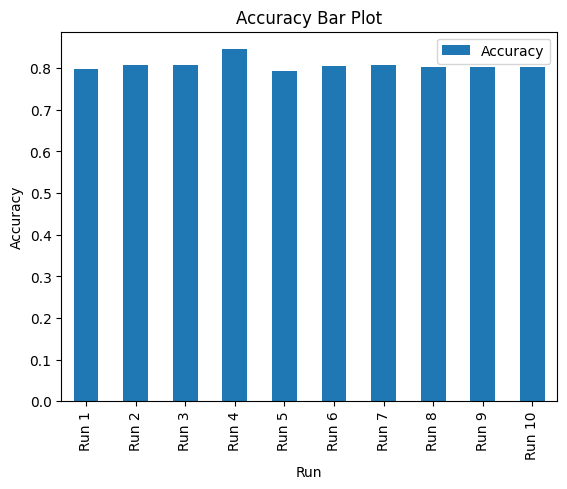

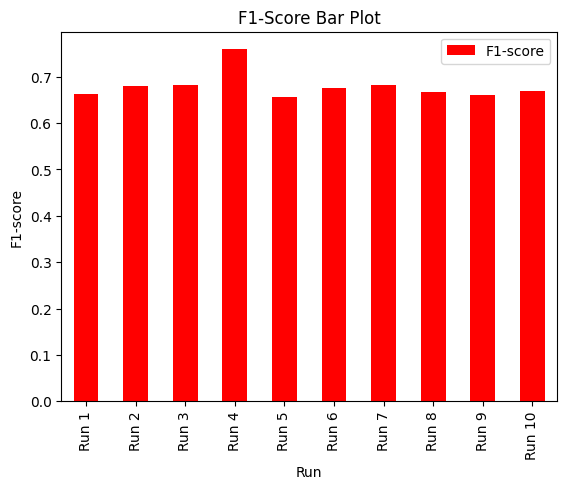

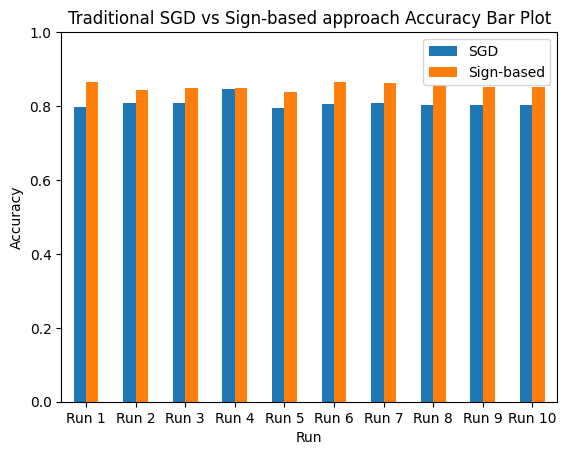

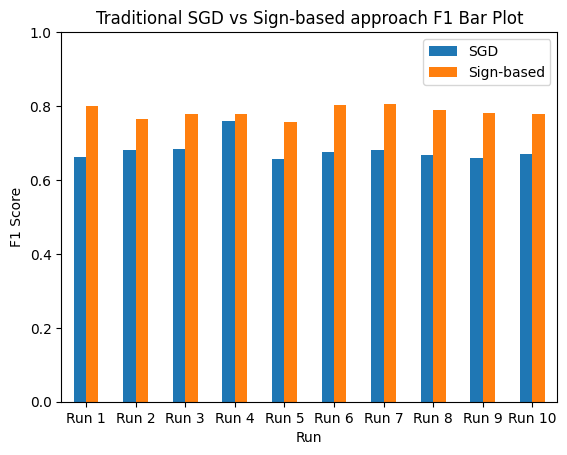